In [1]:
import xarray as xr
from matplotlib import pyplot as plt, cm, colors, colorbar
import cartopy.crs as ccrs
import numpy as np
import scipy as sp
import warnings
import networkx as nx
import os
import glob
import pandas as pd
import seaborn as sb
import itertools as it
from ipyleaflet import Map, basemaps, basemap_to_tiles, Circle, WidgetControl, \
                        Velocity, Polyline, Marker, Polygon, GeoData, \
                        LayersControl, LayerGroup
from ipywidgets import SelectionSlider, IntSlider, Play, HBox, VBox, jslink, Text, HTML, Layout
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
from geopy.distance import geodesic, lonlat

from shapely import geometry
from shapely.geometry import Point, MultiPoint
from shapely.ops import cascaded_union
import geopandas as gpd
from geovoronoi import voronoi_regions_from_coords, plotting

In [2]:
def add_coords_to_xr(f):
    ds = xr.open_dataset(f)
    ds = ds.expand_dims({'latitude': [ds.latitude], 
                         'longitude':[ds.longitude]})
    return ds

def get_coords(f):
    ds = xr.open_dataset(f)
    return (ds.longitude, ds.latitude)

def get_name(f):
    ds = xr.open_dataset(f)
    return ds.source

def to_latlon(coords):
    return (coords[1], coords[0])

def resample(f, start, end, var, unit, mask_days):
    ds = xr.open_dataset(f)
    if mask_days:
        # only keep data at times between civil dusk and dawn (6 degrees below horizon)
        ds = ds.where(ds.solarpos < -6)
    ds = ds.sel(time=slice(start,end))[var]
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore', message='Mean of empty slice')
        ds = ds.resample(time=unit, skipna=True).reduce(np.nanmean)
    t_range = pd.date_range(start, end, freq=unit)
    ds = ds.reindex({'time': t_range})
    return ds
    
def load_data(path, var='vid', start=None, end=None, t_unit='1H', mask_days=True):
    files = glob.glob(os.path.join(path,'*.nc'))
    data = {get_coords(f) : resample(f, start, end, var, t_unit, mask_days) for f in files} 
    names = {get_coords(f): get_name(f) for f in files}
    t_range = pd.date_range(start, end, freq=t_unit)
    return data, names, t_range

def arr(xarray_1d):
    return xarray_1d.values.flatten()
    

def plot_all_vpts(data, names, t_range, bar=False):
    #data, names, t_range = load_data(path, var, start, end, t_unit)
    
    fig, ax = plt.subplots(len(data),1,figsize=(15,2*len(data)), sharex=True)
    for i, (coord, ds) in enumerate(data.items()):
        ds_arr = arr(ds)
        
        if bar:
            barwidth = 0.95 * (1 / t_range.shape[0])
            ax[i].bar(t_range, ds_arr, barwidth)
        else:
            ax[i].plot(t_range, ds_arr)
            
        missing = (np.where(np.isnan(ds_arr))[0].size/ds_arr.size)*100
        
        ax[i].text(*(.98, .95), f'{names[coord]} [{missing:.0f}% missing]',  
                   horizontalalignment = 'right', va = "top",
                   transform = ax[i].transAxes, fontsize=12)
    plt.subplots_adjust(hspace=0)

### Partition of Space - The Voronoi Diagram

In [3]:
class Spatial:
    def __init__(self, radars, epsg='4326', epsg_local='3035'):
        """
        Initialization of Spatial object
        Args:
            radars (dict): mapping from radar coordinates (lon, lat) to names
            epsg (str): coordinate reference system as epsg string 
            epsg_local (str): coordinate reference system as epsg string 
        """
        self.radars = radars
        self.epsg = epsg
        self.epsg_local = epsg_local
        self.N = len(radars)
        
        # projection to local crs
        self.pts_lonlat = gpd.GeoSeries([Point(xy) for xy in radars.keys()], 
                            crs=f'EPSG:{epsg}')
        self.pts_local = self.pts_lonlat.to_crs(epsg=epsg_local)
        
    
    def voronoi(self, buffer=150_000, plot=False):
        """
        Construct Voronoi diagram based on radar coordinates
        Args:
            buffer (float): max distance around radar stations (in meters)
            plot (bool): if True, plot Voronoi diagram
        Returns:
            adj (GeoDataFrame): edges between neighbouring radars, weight=distance [m]
            cells (GeoDataFrame): polygons describing the Voronoi cells
        """
        coords = self.pts2coords(self.pts_local)
        boundary = MultiPoint(self.pts_local).buffer(buffer)
        polygons, pts, poly2pt = voronoi_regions_from_coords(coords, boundary)
        
        idx = np.array(poly2pt).flatten().argsort()       
        cells = gpd.GeoSeries(np.array(polygons)[idx], 
                                   crs=f'EPSG:{self.epsg_local}')
        
        adj = np.zeros((self.N, self.N))
        edges = []
        for i, j in it.combinations(cells.index, 2):
            intersec = cells.iloc[i].intersection(cells.iloc[j])
            if type(intersec) is geometry.LineString:
                adj[i,j] = self.distance(coords[i], coords[j], 
                                           epsg=self.epsg_local)
                adj[j,i] = adj[i,j]
                edges.append(geometry.LineString((coords[i], coords[j])))
                
        self.cells = cells
        self.adj = adj
        self.max_dist = np.max(adj)
        self.edges = gpd.GeoSeries(edges, crs=f'EPSG:{self.epsg_local}')
        
        if plot:
            fig, ax = plotting.subplot_for_map(figsize=(7,7))
            plotting.plot_voronoi_polys_with_points_in_area(ax, 
                        boundary, polygons, coords, poly2pt)
            self.edges.plot(ax=ax)
            plt.show()
            
        return adj, cells
        
        
    def pts2coords(self, pts, reverse_xy=False):
        """
        Convert point objects to [x, y] coordinates
        Args:
            reverse_lonlat (bool): if true, the order of the two coordinates is switched 
        Returns:
            coords: np.array of projected coordinates
        """
        coords = np.array([[p.xy[0][0], p.xy[1][0]] for p in pts])
        if reverse_xy: 
            coords = np.flip(coords, axis=1)
        return coords
    
    
    def distance(self, coord1, coord2, epsg):
        """
        Compute distance between two geographical locations
        Args:
            coord1 (tuple): coordinates of first location (lon, lat) or (x, y)
            coord2 (tuple): coordinates of second location (lon, lat) or (x, y)
        Returns:
            dist (float): distance in meters
        """
        if epsg == self.epsg_local:
            dist = np.linalg.norm(np.array(coord1)-np.array(coord2))
        elif epsg == '4326':
            dist = geodesic(self.flip(coord1), self.flip(coord2)).meters
        else:
            dist = None # raise error?
        return dist
            
    
    def flip(self, coord):
        return (coord[1], coord[0])

### Visualization

In [4]:
def construct_circle(coord, data, time):
    circle = Circle()
    circle.location = to_latlon(coord)
    circle.radius = 25*1000 # [in meters]
    circle.stroke = False
    circle.fill_opacity = 1
    
    d = data.sel(time=time, 
                 lon=coord[0],
                 lat=coord[1])
    
    c = colors.rgb2hex(cmap(norm(d)))
    circle.color = 'gray'
    circle.fill_color = c
    
    return circle

def construct_arrow(coord, data, time):
    lon = coord[0]
    lat = coord[1]
    
    s = 0.1
    u = s * float(data.sel(time=time, lon=lon, lat=lat).u)
    v = s * float(data.sel(time=time, lon=lon, lat=lat).v)

    norm = np.linalg.norm([2*v, u])*5
    norm = np.linalg.norm([2*v, u])
    u_n = u/(norm*5)
    v_n = v/(norm*5)
    line = Polyline(
        locations=[
            [lat-v_n, lon-u_n],
            [lat+v_n, lon+u_n]
        ],
        color="green" ,
        fill=False,
        #line_cap='square',
        weight = int(1+ np.nan_to_num(norm)*3)
    )
    
    s_head = 0.1 
    polygon = Polygon(
        locations=[
            [lat+v_n-u*s_head, lon+u_n+2*v*s_head], 
            [lat+v_n+v*s_head, lon+u_n+u*s_head],
            [lat+v_n+u*s_head, lon+u_n-2*v*s_head]
        ],
        color="green",
        fill_color="green",
        fill_opacity = 1,
        weight = 1
    )
    
    return line, polygon

### Correlations

In [5]:
def all_data(data):
    all_data = []
    for c, d in data.items():
        all_data.append(np.array(d))
    all_data = np.concatenate(all_data)
    return all_data

def angle_from_latlon(lon1, lat1, lon2, lat2):
    
    y = lon1-lon2
    x = lat1-lat2

    brng = np.arctan2(y, x)
    brng = np.rad2deg(brng)
    brng = (brng + 360) % 360

    return brng

def compute_corr(x, y, lag):
    if lag > 0:
        x = x[:x.size-lag]
        y = y[lag:]
    else:
        x = x[-lag:]
        y = y[:y.size+lag]
    
    x_mask = np.isfinite(x)
    y_mask = np.isfinite(y)
    xy_mask = np.logical_and(x_mask, y_mask)

    x = x[xy_mask]
    y = y[xy_mask]

    r, p = sp.stats.pearsonr(x, y)
    
    return r, p
    

def corr(data, names, lag, neighbours_only=False):
    dist_lon = []
    dist_lat = []
    dist = []
    angle = []
    pearsonr = []
    
    spatial = Spatial(names)
    adj, _ = spatial.voronoi()
    mapping = {ci : idx for idx, ci in enumerate(names.keys())}
    for ci, cj in it.permutations(names.keys(), 2):
        d = geodesic(lonlat(*ci), lonlat(*cj)).kilometers
        if neighbours_only:
            cond = (adj[mapping[ci], mapping[cj]] > 0)
        else:
            cond = True
        if cond:
            dist_lon.append(cj[0]-ci[0])
            dist_lat.append(cj[1]-ci[1])
            dist.append(d)
            angle.append(np.abs(angle_from_latlon(*cj, *ci))) # from ci to cj
            
            # corr of earlier time point at ci with later time point at cj
            x = data[ci].values.flatten()
            y = data[cj].values.flatten()
            
            r, p = compute_corr(x, y, lag)
            
            pearsonr.append(r)
        
    fig, ax = plt.subplots(1, 2, figsize=(12,3))
    
    #ax[0].scatter(angle, pearsonr, c=dist)
    #ax[2].scatter(dist_lat, pearsonr, c=dist)
    #ax[2].scatter(dist, pearsonr)
    #ax[0].set_xlabel('angle')
    #ax[2].set_xlabel('lat diff')
    #ax[2].set_xlabel('dist')
    #ax[2].axvline(dist_lat[np.argmax(pearsonr)], ls = '--')
    
    if neighbours_only:
        bins = np.linspace(-1.5, 1.5, 4)
    else:
        bins = np.linspace(-5.5, 5.5, 12)
    A = np.vstack((np.digitize(dist_lat, bins), pearsonr)).T
    means = [np.mean(A[A[:, 0] == i, 1]) for i in range(len(bins))]
    std = [np.std(A[A[:, 0] == i, 1]) for i in range(len(bins))]
    maxr = [np.max(A[A[:, 0] == i, 1]) for i in range(len(bins))]
    #ax[3].errorbar(bins-(bins[1]-bins[0])/2, means, std)
    #ax[3].plot(bins-(bins[1]-bins[0])/2, maxr)
    
    binsize = (bins[1]-bins[0])/2
    binc = bins - binsize
    binc = np.append(binc, bins[-1]+binsize)
    lats = [binc[i] for i in np.digitize(dist_lat, bins)]
    df = pd.DataFrame({'corr' : pearsonr, 'lat diff' : lats})
    ax[0].axvline(int(bins.size/2), ls = '--', c='lightgray')
    ax[0] = sb.boxplot(x="lat diff", y="corr", data=df, color='gray', ax=ax[0])
    ax[0].set_ylim(0,1)
    ax[0].set_title(f'Lag = {lag}h')
    
    if neighbours_only:
        bins = np.linspace(0, 360, 9)[1:]
    else:
        bins = np.linspace(0, 360, 17)[1:]
    A = np.vstack((np.digitize(angle, bins), pearsonr)).T
    means = np.array([np.mean(A[A[:, 0] == i, 1]) for i in range(len(bins))])
    std = np.array([np.std(A[A[:, 0] == i, 1]) for i in range(len(bins))])
    maxr = [np.nanmax(A[A[:, 0] == i, 1]) for i in range(len(bins))]
    #ax[1].errorbar(bins-(bins[1]-bins[0])/2, means, std)
    #ax[1].plot(bins-(bins[1]-bins[0])/2, maxr)
    
    binsize = (bins[1]-bins[0])/2
    binc = bins - binsize
    binc = np.append(binc, bins[-1]+binsize)
    angles = np.array([binc[i] for i in np.digitize(angle, bins)])
    angles = angles/360 * 2*np.pi
    df = pd.DataFrame({'corr' : pearsonr, 'angle' : angles})
    #ax[1] = sb.boxplot(x="angle", y="corr", data=df, color='gray', ax=ax[1])

    ax[1].remove()
    x = (bins-(bins[1]-bins[0])/2)/360 *2*np.pi
    axis = fig.add_subplot(1, 2, 2, projection='polar')
    bars = axis.bar(x, means, width=0.3, bottom=0, yerr=std, ecolor='gray')
    #bars = axis.errorbar(bins-(bins[1]-bins[0])/2, means, std)
    #x = (bins-(bins[1]-bins[0])/2)/360 *2*np.pi
    #axis.plot(x, means, c='blue')
    #axis.fill_between(x, means-std, means+std,
    #       alpha=0.5, edgecolor='blue', facecolor='blue')
    
    # Use custom colors and opacity
    for r, bar in zip(means, bars):
        bar.set_facecolor(plt.cm.jet(r))
        #bar.set_alpha(1)
    
    axis.set_rlim(0,1)
    axis.set_theta_zero_location("N")
    axis.set_theta_direction(-1)
    
def angle_to_rad(angle):
    return angle / 360 * 2 * np.pi

def corr_neighbours(data_list, names_list, lags, neighbours_only=True, title='', plot='angle', preferred_dir=215):
    
    rows = []
    
    preferred_dir = angle_to_rad(preferred_dir)
    
    if neighbours_only:
        bins_lat = np.linspace(-1.5, 1.5, 4)
        bins_dist = np.linspace(-500, 500, 9)
    else:
        bins_lat = np.linspace(-5, 5, 6)
        bins_dist = np.linspace(-500, 500, 5)
        
    

    bins_angle = np.linspace(0, 360, 9)[1:]
    
    def binc(bins, var=None):
        
        if var == 'rel dist':
            binsize = bins[1]-bins[0]
            binc = np.array([f'{bins[i]} to {bins[i+1]}' for i in range(len(bins)-1)])
            binc = np.concatenate(([f'<{bins[0]}'], binc, [f'>{bins[-1]}']))
        else:
            binsize = (bins[1]-bins[0])/2
            binc = np.append(bins-binsize, bins[-1]+binsize)
        return binc
    
    for data, names in zip(data_list, names_list):
        spatial = Spatial(names)
        adj, _ = spatial.voronoi()
        mapping = {ci : idx for idx, ci in enumerate(names.keys())}
        for ci, cj in it.permutations(names.keys(), 2):
            if neighbours_only:
                cond = (adj[mapping[ci], mapping[cj]] > 0)
            else:
                cond = True
            if cond:
                for lag in lags:
                    x = data[ci].values.flatten()
                    y = data[cj].values.flatten()

                    r, p = compute_corr(x, y, lag)
                    rows.append({'diff lat': binc(bins_lat)[np.digitize(cj[1]-ci[1], bins_lat)], 
                                 'angle': angle_to_rad(binc(bins_angle)[np.digitize(np.abs(angle_from_latlon(*cj, *ci)), bins_angle)]),
                                 'rel dist': binc(bins_dist, 'rel dist')[np.digitize(geodesic((ci[1], ci[0]), (cj[1], cj[0])).kilometers / 
                                                                         np.cos(angle_to_rad(angle_from_latlon(*cj, *ci)) - preferred_dir),
                                                                         bins_dist)],
                                 'lag': lag, 
                                 'corr': r})
                
    df = pd.DataFrame(rows)
    
    if plot == 'lat':
        fig, ax = plt.subplots(1, 1, figsize=(18,3))
        fig.suptitle(title)
        ax= sb.boxplot(x="lag", y="corr", data=df, hue="diff lat", ax=ax)
        ax.set_ylim(-0.1,1.1)
        ax.legend(loc='upper right', title='difference in latitude [deg]', bbox_to_anchor=(1.0, 1.0), ncol=len(lags)+1)

    if plot == 'dist':
        fig, ax = plt.subplots(1, 1, figsize=(18,3))
        fig.suptitle(title)
        ax= sb.boxplot(x="lag", y="corr", data=df, hue="rel dist", hue_order=binc(bins_dist, 'rel dist'), ax=ax, palette='Set2')
        ax.set_ylim(-0.3,1.1)
        ax.legend(loc='upper center', title='weighted distance', bbox_to_anchor=(0.5, 1.15), ncol=len(lags)+1, framealpha=1)
        ax.set_xlabel('lag [hours]')
        ax.set_ylabel('correlation coefficient')
    
    
    elif plot == 'angle':
        #fig, ax = plt.subplots(2, int(len(lags)/2), figsize=(len(lags)*2,8), subplot_kw = {'projection' : 'polar'})
        fig, ax = plt.subplots(1, len(lags), figsize=(len(lags)*4,4), subplot_kw = {'projection' : 'polar'})
        pref_dir_corr = []
        index = angle_to_rad(binc(bins_angle))[1]
        
        for idx, lag in enumerate(lags):
            df_lag = df[df.lag==lag]
            df_lag = df_lag.groupby('angle')

            #x = (bins_angle-(bins_angle[1]-bins_angle[0])/2)/360 *2*np.pi
            means = df_lag.mean()['corr']
            i, j = int(lag/int(len(lags)/2)), lag%int(len(lags)/2)
            #bars = ax[i,j].bar(df_lag.mean().index, means, width=0.3, bottom=0, yerr=df_lag.std()['corr'], ecolor='gray')
            bars = ax[idx].bar(df_lag.mean().index, means, width=0.3, bottom=0, yerr=df_lag.std()['corr'], ecolor='gray')
            for r, bar in zip(means, bars):
                bar.set_facecolor(cm.jet(r))

            #ax[i,j].set_rlim(0,1)
            #ax[i,j].set_theta_zero_location("N")
            #ax[i,j].set_theta_direction(-1)
            #ax[i,j].set_title(f'lag = {lag}h', pad=20)
            
            ax[idx].set_rlim(0,1)
            ax[idx].set_theta_zero_location("N")
            ax[idx].set_theta_direction(-1)
            ax[idx].set_title(f'lag = {lag}h', pad=20)
            #ax[i].colorbar()
            
            
            pref_dir_corr.append(df_lag.get_group(index)['corr'].to_numpy())

        cmap = cm.jet
        #ax[-1].remove()
        #axis = fig.add_subplot(1, len(lags), len(lags))
        axis = fig.add_axes([0.95, 0.25, 0.02, 0.5])
        cb = colorbar.ColorbarBase(axis, cmap=cmap,
                                        orientation='vertical')
        cb.set_label('correlation coefficient')

        plt.subplots_adjust(wspace=0.3)
        plt.subplots_adjust(hspace=0.4)
        
        fig2, ax2 = plt.subplots()
        pref_dir_corr = np.vstack(pref_dir_corr)
        mu = np.mean(pref_dir_corr, axis=1)
        std = np.std(pref_dir_corr, axis=1)
        ax2.plot(lags, mu)
        ax2.fill_between(lags, mu-std, mu+std, alpha=0.2)
    return fig, fig2
    
def corr_matrix(data, names, lag=1):
    coord_list = sorted(list(names.keys()), key=lambda x: x[1], reverse=True)
    codes = [names[ci] for ci in coord_list]
    N = len(data)
    corr = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            x = data[coord_list[i]].values.flatten()
            y = data[coord_list[j]].values.flatten()

            r, p = compute_corr(x, y, lag)
            corr[i, j] = r
        
    fig, ax = plt.subplots(figsize=(10,8))
    sb.heatmap(pd.DataFrame(corr), cmap='RdBu_r', ax=ax)
    ax.set(title=f'cross-correlation with lag={lag}', ylabel='time t', xlabel=f'time t+{lag}')
    ax.set_yticklabels(codes, rotation=0)
    ax.set_xticklabels(codes, rotation=90)
    
#     spatial = Spatial(names)
#     adj, _ = spatial.voronoi()
#     mapping = {ci : idx for idx, ci in enumerate(names.keys())}
    
#     for i in range(N):
#         for j in range(N):
#             dist = adj[mapping[coord_list[i]], mapping[coord_list[j]]]
#             if dist > 0:
#                 text = ax.text(j, i, '1',
#                                ha="left", va="top", color="black")
    
def spatio_temp_corr(rcode, data, names, lags):

    coord_list = list(names.keys())
    names_list = np.array(list(names.values()))
    
    spatial = Spatial(names)
    adj, _ = spatial.voronoi()
    mapping = {ci : idx for idx, ci in enumerate(names.keys())}

    ci = {v:k for k,v in names.items()}[rcode]
    di = data[ci]
    sorted_radars = dict(sorted(names.items(), key=lambda x: geodesic(lonlat(*ci), lonlat(*x[0])).kilometers))
    corr = []
    codes = []
    for cj in list(sorted_radars.keys()):
        if adj[mapping[ci], mapping[cj]] > 0:
            codes.append(f'** {names[cj]}')
        else:
            codes.append(names[cj])
        corr.append([])
        for lag in lags:
            x = data[ci].vlaues.flatten()
            y = data[cj].values.flatten()
            
            r, p = compute_corr(x, y, lag)
            corr[-1].append(r)

    fig, ax = plt.subplots(figsize=(10,5))
    sb.heatmap(pd.DataFrame(corr), cmap='RdBu_r', ax=ax)
    ax.set(title=rcode, xlabel='Lag [hours]',ylabel='Radars')
    ax.set_yticklabels(codes, rotation=0)
    ax.set_xticklabels(np.array(lags))


In [7]:
bins = np.linspace(-300, 300, 9)
binsize = bins[1]-bins[0]
binc = np.array([f'{bins[i]} to {bins[i+1]}' for i in range(len(bins)-1)])
binc = np.concatenate(([f'<{bins[0]}'], binc, [f'>{bins[-1]}']))
print(bins)
print(binc)

[-300. -225. -150.  -75.    0.   75.  150.  225.  300.]
['<-300.0' '-300.0 to -225.0' '-225.0 to -150.0' '-150.0 to -75.0'
 '-75.0 to 0.0' '0.0 to 75.0' '75.0 to 150.0' '150.0 to 225.0'
 '225.0 to 300.0' '>300.0']


### Load Vertical Profile Data - Autumn 2016

In [17]:
#path = '/home/fiona/radar_data/vpi/night_only/20160801T0000_to_20161130T2359'
#begin = '2016-09-01'
#end = '2016-11-01'

path = '/home/fiona/radar_data/vpi/night_only/20160301T0000_to_20160530T2359'
begin = '2016-03-01'
end = '2016-05-01'

# vid_data_16, names_16, t_range_16 = load_data(path, 'vid', begin, end, '1H', mask_days=True)
# uv_data, _, _ = load_data(path, ['u', 'v'], begin, end, '1H')
# ff_data, _, _ = load_data(path, 'ff', begin, end, '1H')

vid_data_16, names_16, t_range_16 = load_data(path, 'vid', begin, end, '1H', mask_days=True)
solarpos, radars, t_range = load_data(path, 'solarpos', begin, end, '1H', mask_days=False)

<xarray.DataArray 'vid' (time: 847, lon: 847, lat: 847)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, Fal

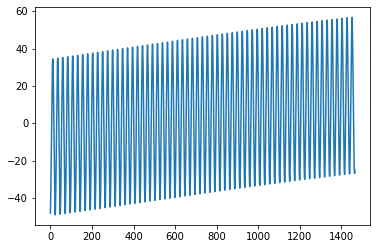

In [18]:
for r in radars.keys():
    ridx = np.isfinite(vid_data_16[r])
    sidx = np.where(solarpos[r]>-6)
    print(ridx[sidx])
    break
    
plt.plot(np.array(solarpos[r]).flatten())

In [25]:
start = t_range[0]
end = t_range[-4]

t_range[np.where(t_range==start)[0][0]:np.where(t_range==end)[0][0]+1]
t_range

DatetimeIndex(['2016-03-01 00:00:00', '2016-03-01 01:00:00',
               '2016-03-01 02:00:00', '2016-03-01 03:00:00',
               '2016-03-01 04:00:00', '2016-03-01 05:00:00',
               '2016-03-01 06:00:00', '2016-03-01 07:00:00',
               '2016-03-01 08:00:00', '2016-03-01 09:00:00',
               ...
               '2016-04-30 15:00:00', '2016-04-30 16:00:00',
               '2016-04-30 17:00:00', '2016-04-30 18:00:00',
               '2016-04-30 19:00:00', '2016-04-30 20:00:00',
               '2016-04-30 21:00:00', '2016-04-30 22:00:00',
               '2016-04-30 23:00:00', '2016-05-01 00:00:00'],
              dtype='datetime64[ns]', length=1465, freq='H')

### Time Series Inspection

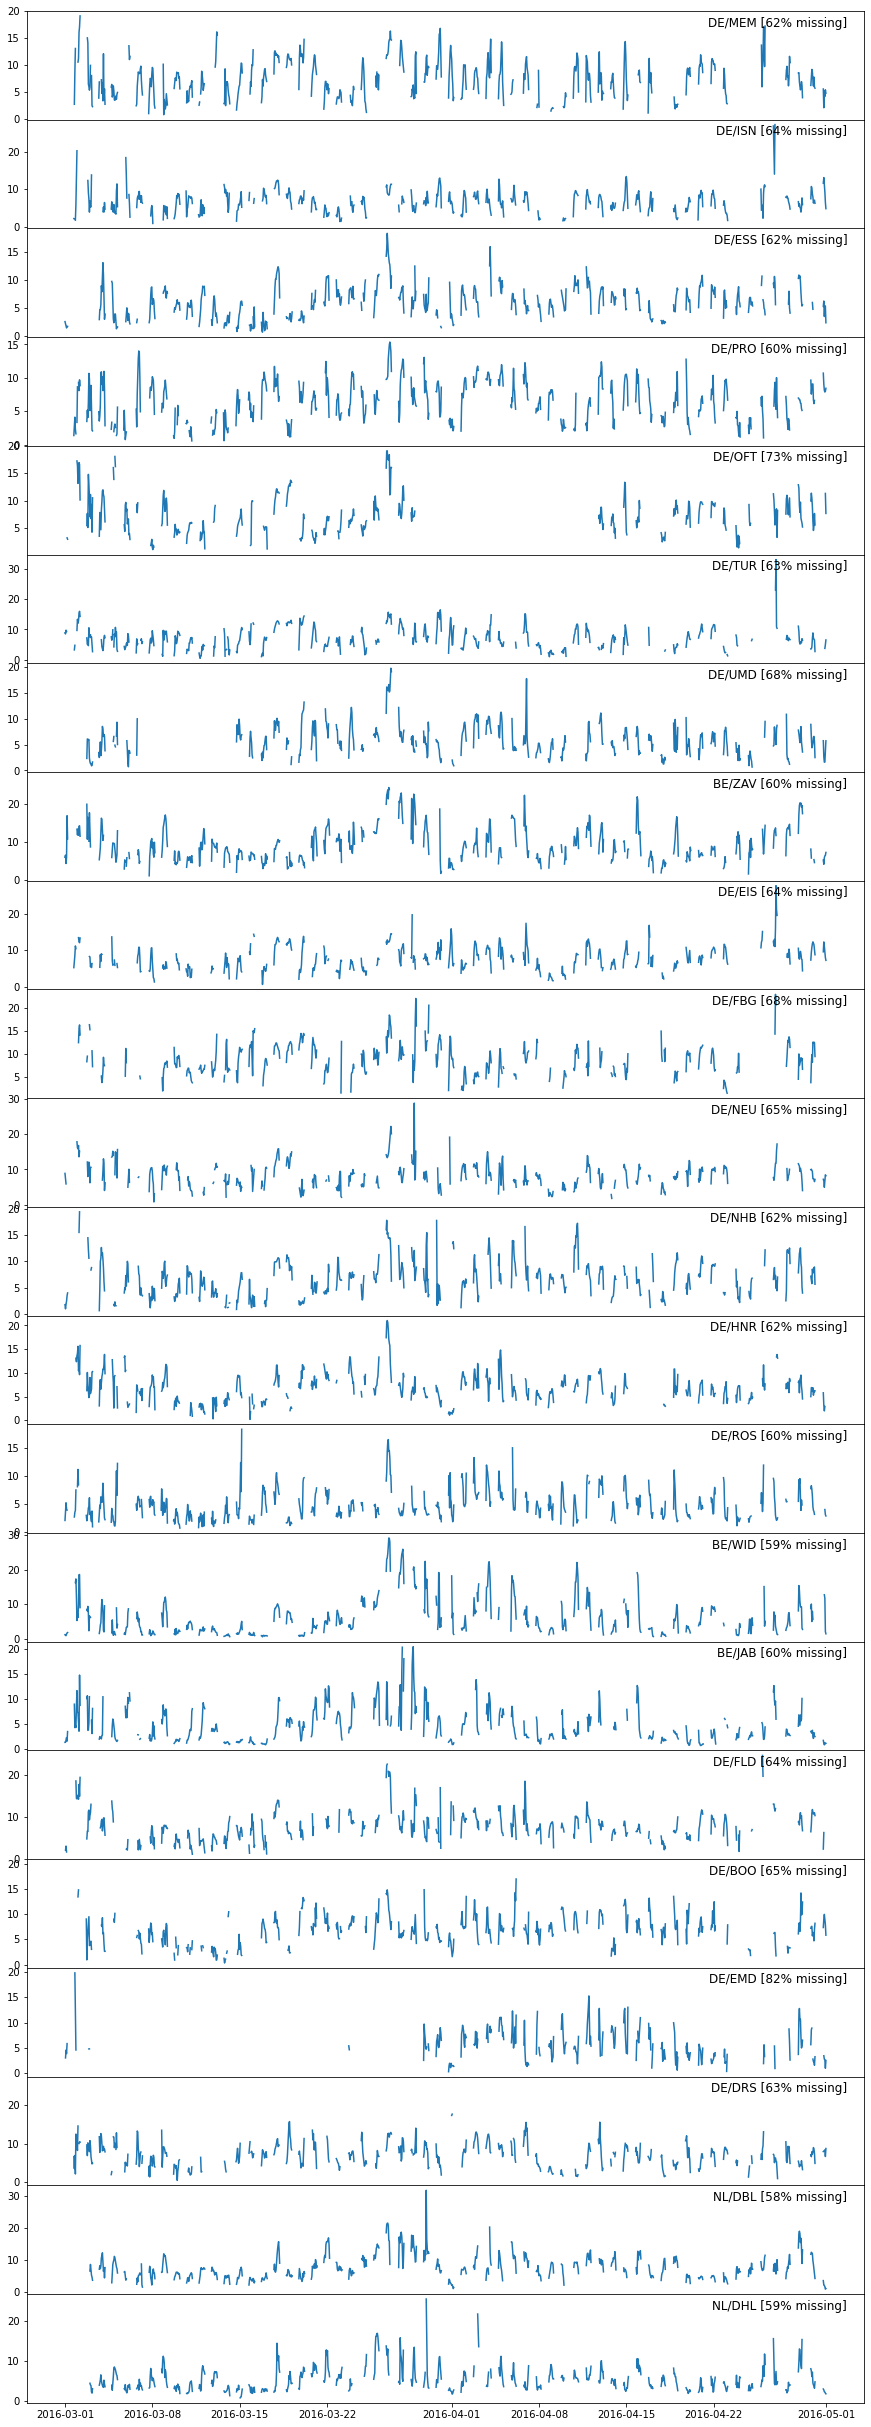

In [7]:
plot_all_vpts(ff_data, names_16, t_range_16, bar=False)

### Visualization

In [84]:
cmax = 200
cmap = cm.get_cmap('YlOrRd')
norm = colors.Normalize(vmin=0.,vmax=cmax)
#norm = colors.LogNorm(vmin=0.,vmax=500)


m = Map(center=(51, 10), zoom=6)
m.layout.height = '750px'


spatial = Spatial(names_16)
spatial.voronoi()
print(spatial.adj[spatial.adj > 0].min())
print(spatial.adj[spatial.adj > 0].max())
edges = spatial.edges.to_frame(name='geometry').to_crs(epsg=spatial.epsg)
edges = GeoData(geo_dataframe = edges, name='connections',
        style={'color': 'gray', 'opacity':0.8, 'weight':2, 'dashArray':'2 4'})
m.add_layer(edges)

cells = spatial.cells.to_frame(name='geometry').to_crs(epsg=spatial.epsg)
cells = GeoData(geo_dataframe = cells, name='cells',
        style={'color': '#336699', 'opacity':0.8, 'fill_opacity':0.1, 'weight':4})
m.add_layer(cells)


markers = {}
info = {}
lines = {}
arrow_heads = {}
for coord in vid_data_16.keys():
    markers[coord] = construct_circle(coord, vid_data_16[coord], str(t_range_16[0]))
    
    info[coord] = Marker(location=to_latlon(coord), 
                  draggable=False, 
                  title=names_16[coord], 
                  opacity=0)
    
    lines[coord], arrow_heads[coord] = construct_arrow(coord, 
                                        uv_data[coord], str(t_range_16[0]))
    
all_info = LayerGroup(layers=tuple(info.values()), name='info')
all_markers = LayerGroup(layers=tuple(markers.values()), name='markers')
arrows = tuple(lines.values())+tuple(arrow_heads.values())
all_arrows = LayerGroup(layers=arrows, name='arrows')

layer_control = LayersControl(position='topright')
m.add_control(layer_control)
m.add_layer(all_info)
m.add_layer(all_markers)
m.add_layer(all_arrows)



slider = IntSlider(description='time step:', 
                    value=0,
                    min=0,
                    max= len(t_range_16)-1,
                    step=1,
                    orientation='horizontal',
                    layout={'width': '500px'}
)
time_info = Text(value=str(t_range_16[slider.value]),
                    description='Datetime:'
)
play = Play(max = len(t_range_16) - 1, interval=500)
jslink((play, 'value'), (slider, 'value'))
widget_control = WidgetControl(widget=HBox([play, slider, time_info]), 
                               position='topright')
m.add_control(widget_control)

legend = {int(val) : colors.rgb2hex(cmap(norm(val))) for val in np.linspace(0, cmax, 6)}
layout = Layout(display='flex',
                    flex_flow='column',
                    align_items='stretch',
                    width='70px')

v = lambda val: f'''
<div style="width:25px;height:25px;background-color:{legend[val]};
display:inline-block;"></div>
<div style="width:35px;height:25px;display:inline-block; text-align:right;
position:absolute;top: 0%;">{val}</div>'''

legend = [HTML(value='<b>Birds/km2</b>')]+[HTML(value= v(val))for val in legend.keys()]
legend = WidgetControl(widget=HBox(legend, layout=layout), position='bottomright')
m.add_control(legend)

def update(change):
    for coord, data in vid_data_16.items():
        time = str(t_range_16[slider.value])
        vid = data.sel(time=time, lon=coord[0], lat=coord[1])
        if np.isfinite(float(vid)):
            c = colors.rgb2hex(cmap(norm(vid)))
            markers[coord].fill_color = c
            markers[coord].fill_opacity = 1
        else:
            markers[coord].fill_opacity = 0
        
        uv = uv_data[coord].sel(time=time, lon=coord[0], lat=coord[1])
        if np.isfinite(float(uv.u)) and np.isfinite(float(uv.v)):
            line, polygon = construct_arrow(coord, uv_data[coord], time)
            lines[coord].locations = line.locations
            lines[coord].weight = line.weight
            arrow_heads[coord].locations = polygon.locations
            arrow_heads[coord].fill_opacity = 1
            arrow_heads[coord].opacity = 1
        else:
            arrow_heads[coord].fill_opacity = 0
            arrow_heads[coord].opacity = 0
            lines[coord].weight = 0
        
    time_info.value = str(t_range_16[slider.value])

slider.observe(update, 'value')
display(m)

68458.32454485091
291728.2694168371


Map(center=[51, 10], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

### Load Data - Autumn 2015, 2016, 2017, 2018

In [8]:
years = ['2015', '2016', '2017', '2018']
vid_data = {}
dd_data = {}
ff_data = {}
radars = {}

season = 'fall'

for y in years:
    
    if season == 'fall':
        begin = f'{y}-08-01 12:00'
        end = f'{y}-11-15 11:00'
        path = f'/home/fiona/radar_data/vpi/night_only/{y}0801T0000_to_{y}1130T2359'
        
    elif season == 'spring':
        begin = f'{y}-03-01 12:00'
        end = f'{y}-05-30 11:00'
        path = f'/home/fiona/radar_data/vpi/night_only/{y}0301T0000_to_{y}0530T2359'
        
    vid_data[y], radars[y], t_range = load_data(path, 'vid', begin, end, '1H', mask_days=True)
    dd_data[y], _, _ = load_data(path, 'dd', begin, end, '1H', mask_days=True)
    ff_data[y], _, _ = load_data(path, 'ff', begin, end, '1H', mask_days=True)

In [9]:
def angle_from_uv(u, v):

    brng = np.arctan2(u, v)
    brng = np.rad2deg(brng)
    brng = (brng + 360) % 360

    return brng

def angle_from_dd(dd):

    angle = (dd + 360) % 360

    return angle

angles = []
speeds = []
vid = []
for y in years:
    for r in radars[y]:
        #angles.extend([angle_from_uv(u,v) for u,v in zip(np.array(uv_data[y][r].u).flatten(), np.array(uv_data[y][r].v).flatten())])
        angles.extend(angle_from_dd(np.array(dd_data[y][r]).flatten()))
        speeds.extend(np.array(ff_data[y][r]).flatten())
        vid.extend(np.array(vid_data[y][r]).flatten())

171.67665


<ipython-input-11-bfe98a9df54e>:14: RuntimeWarning: invalid value encountered in greater
  idx = np.where(np.array(vid)>5)
<ipython-input-11-bfe98a9df54e>:23: RuntimeWarning: invalid value encountered in greater
  idx = np.where(np.array(vid)>5)


195888 47288
421.2468
7.0124774 35.660614 3.4065225


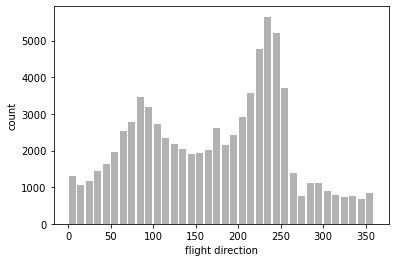

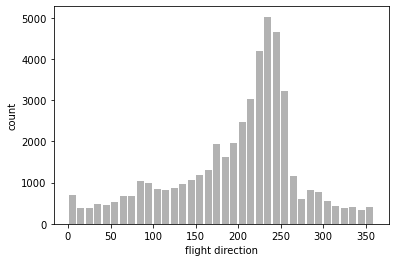

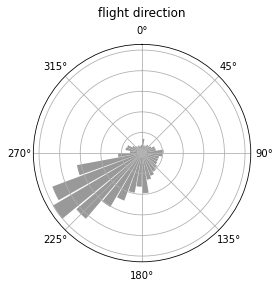

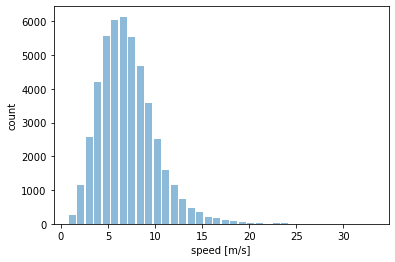

In [11]:
fig, ax = plt.subplots()
#ax.axvspan(210, 230, alpha=0.4, color='red', label='literature values') # fall
#ax.axvline(41, color='red', lw=4, alpha=0.6, label='literature value') # spring
ax.hist(angles, bins=36, rwidth=0.8, alpha=0.6, color='gray')
#ax.axvline(np.nanmean(angles), color='red', ls=':', lw=3)
ax.set_xlabel('flight direction')
ax.set_ylabel('count')
#fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.88))
#fig.savefig('hist_flight_direction_spring.jpg', bbox_inches='tight', dpi=200)
fig.savefig('hist_flight_direction_fall_without_filtering.jpg', bbox_inches='tight', dpi=200)
print(np.nanmean(angles))

fig, ax = plt.subplots()
idx = np.where(np.array(vid)>5)
ax.hist(np.array(angles)[idx], bins=36, rwidth=0.8, alpha=0.6, color='gray')
ax.set_xlabel('flight direction')
ax.set_ylabel('count')
fig.savefig('hist_flight_direction_fall_with_filtering_5.jpg', bbox_inches='tight', dpi=200)
#fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.88))

fig, ax = plt.subplots(subplot_kw = {'projection' : 'polar'})
#ax.axvspan(210, 230, alpha=0.4, color='red', label='literature values') # fall
idx = np.where(np.array(vid)>5)
print(len(vid), idx[0].size)
ax.hist((np.array(angles)/360 * 2 * np.pi)[idx], bins=36, rwidth=0.9, alpha=0.8, color='gray')
ax.set_yticklabels([])
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title('flight direction', y=1.1)
#ax.axvline(np.nanmean(angles), color='red', ls=':', lw=3)
#ax.set_xlabel('flight direction')
#ax.set_ylabel('count')
#fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.88))
fig.savefig('hist_flight_direction_fall_circular.jpg', bbox_inches='tight', dpi=200)
print(np.nanmax(vid))

fig, ax = plt.subplots()
ax.hist(np.array(speeds)[idx], bins=36, rwidth=0.8, alpha=0.5)
#ax.axvline(np.nanmean(speeds), color='red', ls=':', lw=3) # literature mean: 12 m/s
ax.set_xlabel('speed [m/s]')
ax.set_ylabel('count')
#fig.savefig('hist_flight_speed_spring.jpg', bbox_inches='tight', dpi=200);
print(np.nanmean(speeds), np.nanmax(speeds), np.nanstd(speeds))

#speeds_fall = np.array(speeds)[idx]

In [17]:
A = np.ones((3,4,5))
A.shape[1:]
np.ones((1, *A.shape[1:])).shape

(1, 4, 5)

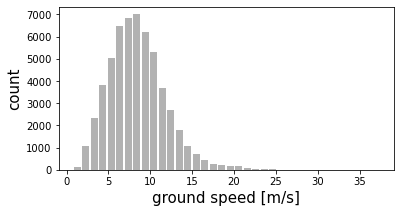

In [91]:
all_speeds = np.concatenate((speeds_spring, speeds_fall))
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(all_speeds, bins=36, rwidth=0.8, alpha=0.6, color='gray')
ax.set_xlabel('ground speed [m/s]', fontsize=15)
ax.set_ylabel('count', fontsize=15)
fig.savefig('hist_groundspeed_spring_and_autumn.jpg', bbox_inches='tight', dpi=200);

In [101]:
radar_means = {}
for y in years:
    for k, v in vid_data[y].items():
        data = np.array(v).flatten()[:-1]
        if k in radar_means:
            radar_means[k] = np.concatenate((radar_means[k], np.reshape(data, (int(data.size/24), 24))), axis=0)
        else:
            radar_means[k] = np.reshape(data, (int(data.size/24), 24))

In [ ]:
for k, v in radar_means.items():
    fig, ax = plt.subplots()
    mu = np.nanmean(v, axis=0)
    std = np.nanstd(v, axis=0)
    ax.plot(range(24), mu)
    ax.fill_between(range(24), mu+std, mu-std, alpha=0.2)

### Cross-Correlation with Varying Time-Lag

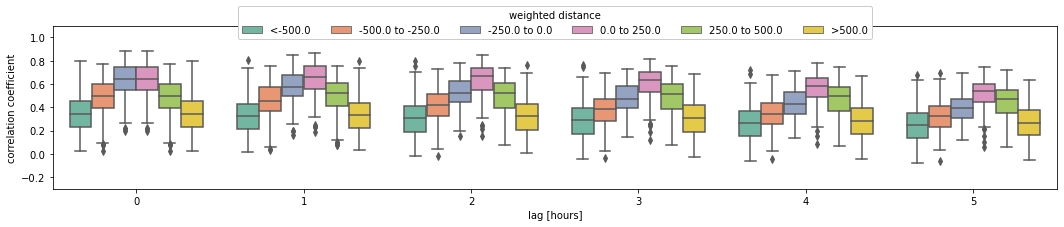

In [130]:
fig = corr_neighbours([vid_data[y] for y in years], [radars[y] for y in years], range(6), neighbours_only=False, title='', plot='dist', preferred_dir=230)
#fig.savefig('cross_corr_all_spring_preferred50.jpg', bbox_inches='tight', dpi=200)

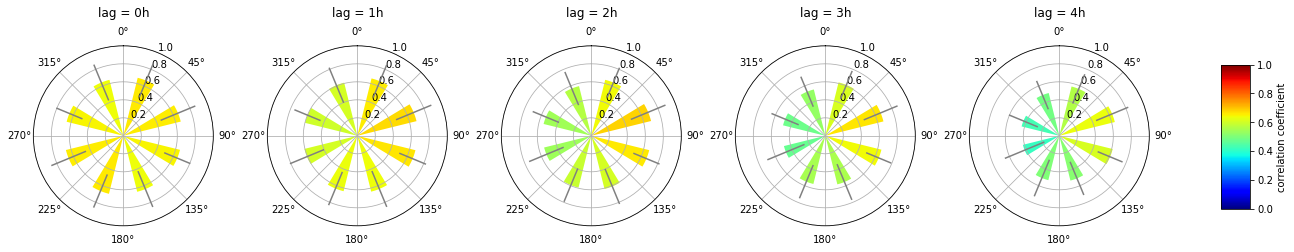

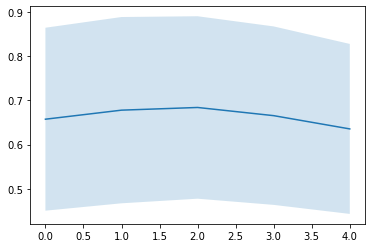

In [82]:
fig, fig2 = corr_neighbours([vid_data[y] for y in years], [radars[y] for y in years], range(5), plot='angle')
#fig.savefig('cross_corr_neighbours_spring.jpg', bbox_inches='tight', dpi=200)

/home/fiona/anaconda3/envs/bird_vis/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


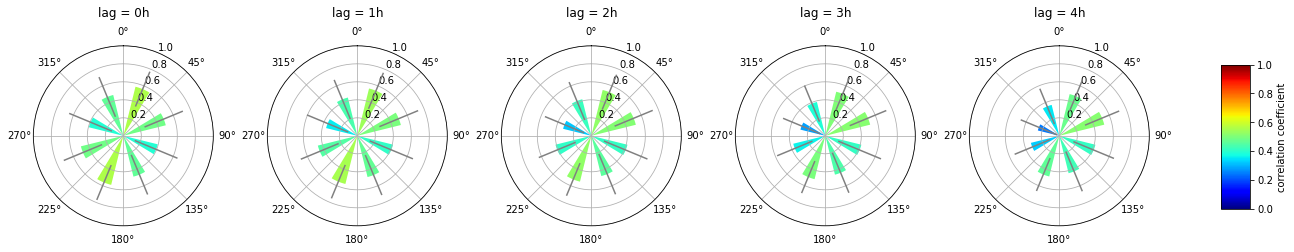

In [140]:
fig = corr_neighbours([vid_data[y] for y in years], [radars[y] for y in years], range(5), neighbours_only=False, plot='angle')
fig.savefig('cross_corr_all_spring.jpg', bbox_inches='tight', dpi=200)

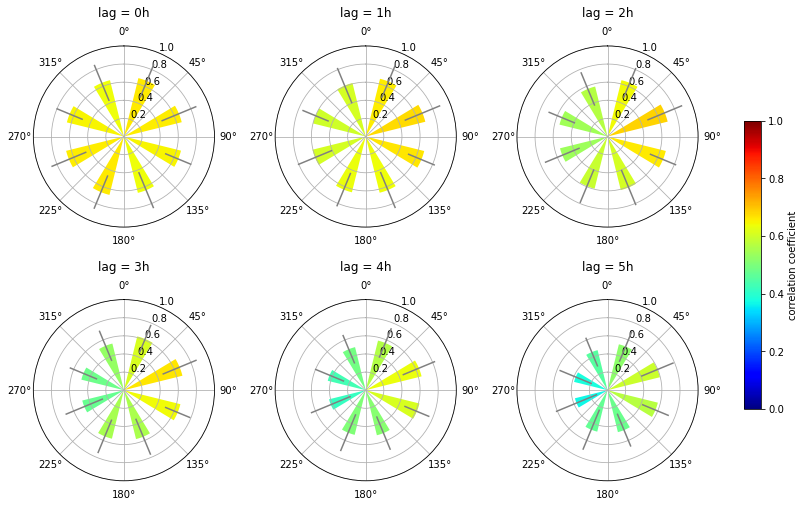

In [125]:
fig = corr_neighbours([vid_data[y] for y in years], [radars[y] for y in years], range(6))
fig.savefig('cross_corr_neighbours_spring.jpg', bbox_inches='tight', dpi=200)

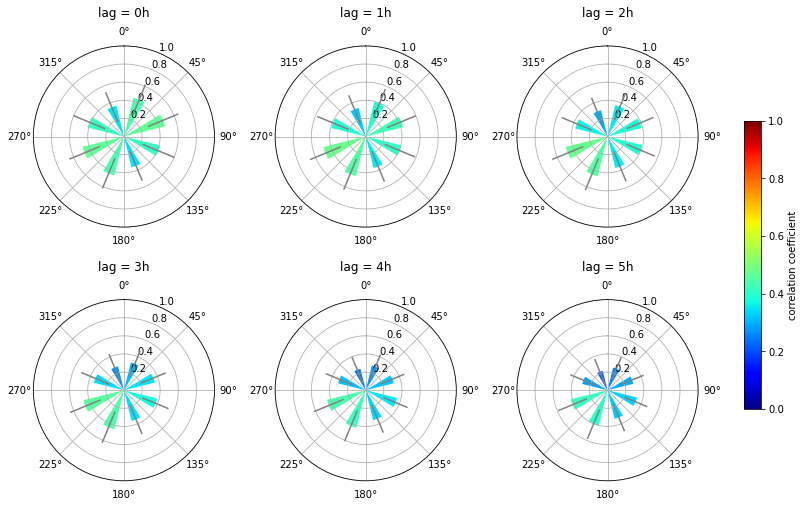

In [129]:
fig = corr_neighbours([vid_data[y] for y in years], [radars[y] for y in years], range(6), neighbours_only=False)
fig.savefig('cross_corr_all_fall.jpg', bbox_inches='tight', dpi=200)

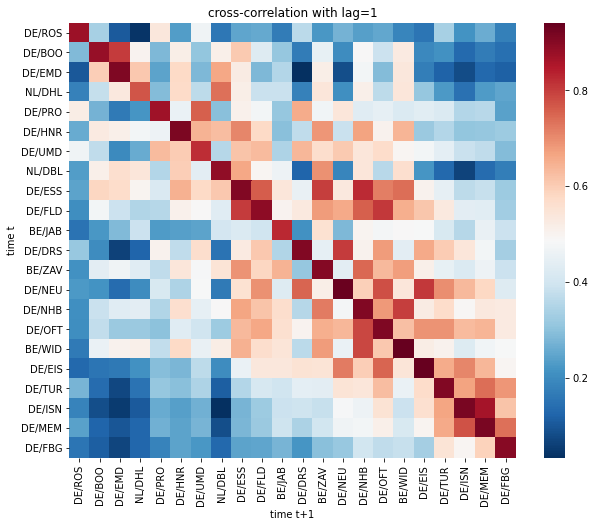

In [132]:
corr_matrix(vid_data['2016'], radars['2016'])

### Predictions with Mass Conservation

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2992.709132139758
            Iterations: 60
            Function evaluations: 152
            Gradient evaluations: 60
DE/ESS: total flux = 1.0000000018640292, 
 weights = [7.45222420e-01 2.06760721e-10 9.65022297e-02 1.22711090e-09
 9.19288654e-02 5.19655310e-04 6.58268298e-02]
DE/OFT: total flux = 1.0000000007939056, 
 weights = [7.76509508e-02 7.08520913e-01 8.83157235e-02 2.48979157e-10
 1.19847824e-01 5.66458950e-03]
DE/TUR: total flux = 1.0, 
 weights = [0.08074568 0.84527183 0.07398248]
DE/UMD: total flux = 1.0000000000000002, 
 weights = [0.67592273 0.04348892 0.13645544 0.08958698 0.05454592]
DE/NEU: total flux = 1.000000002622578, 
 weights = [9.68994881e-11 1.20154817e-01 6.00977010e-09 7.95382393e-01
 8.44627862e-02]
DE/NHB: total flux = 1.0, 
 weights = [0.03173306 0.10327344 0.8649935 ]
DE/HNR: total flux = 1.0000000009671433, 
 weights = [4.04014323e-02 1.09176320e-01 8.17167105e-

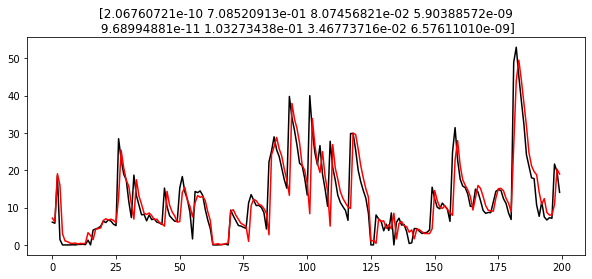

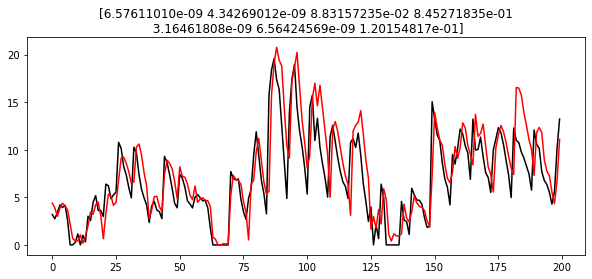

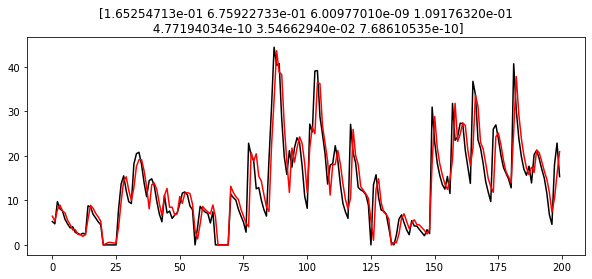

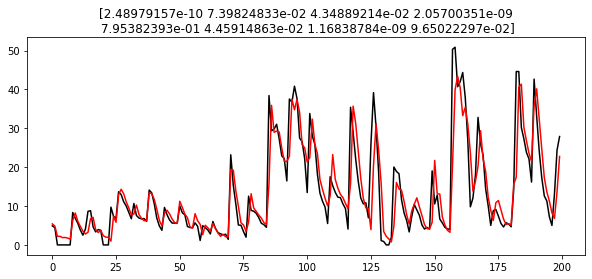

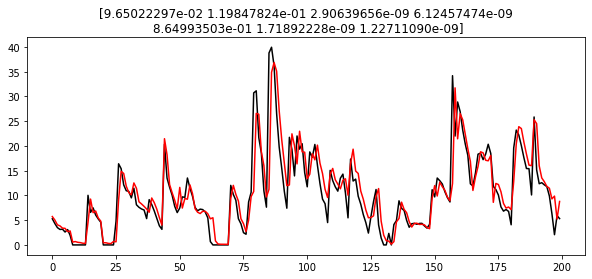

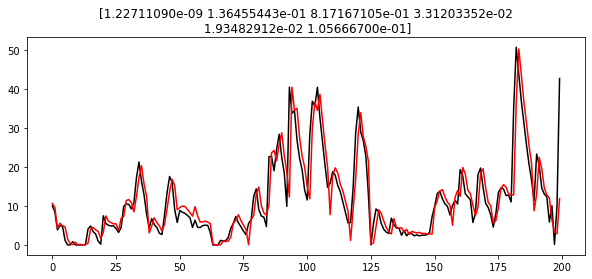

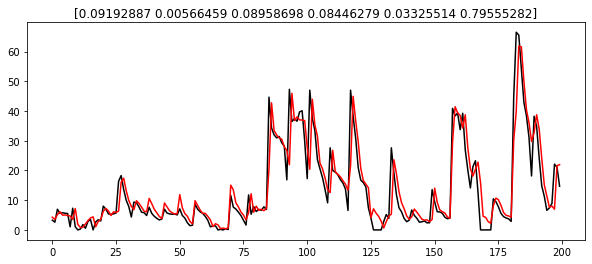

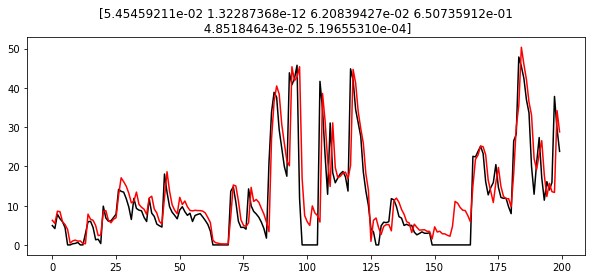

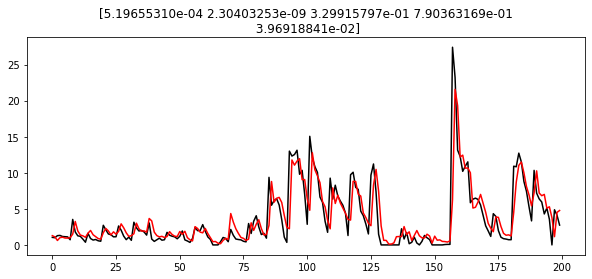

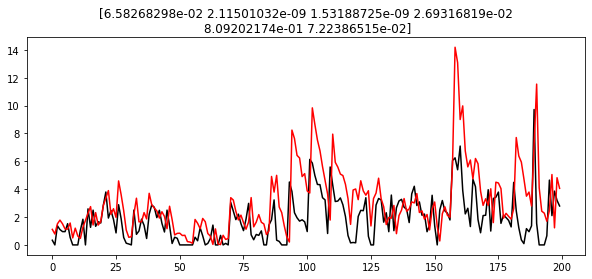

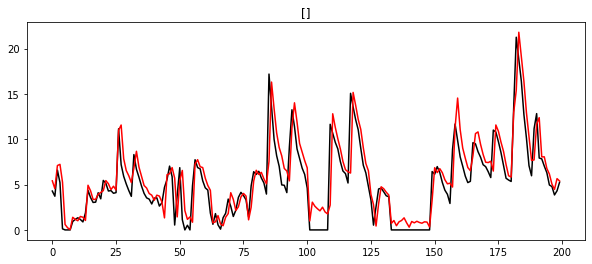

In [376]:
y = '2016'
data = vid_data[y]
names = radars[y]
spatial = Spatial(names)
adj, _ = spatial.voronoi()
mapping = {ci : idx for idx, ci in enumerate(names.keys())}
reverse_map = {idx : ci for ci, idx in mapping.items()}
T = len(t_range)
N = len(names)
d = np.zeros((N,T))

for ci, idx in mapping.items():
    d[idx, :] = arr(data[ci])
    
check = np.isfinite(d).all(axis=0)
X = np.zeros((N, 1))
Y = np.zeros((N, 1))
for t in range(T-1):
    if np.all(check[t:t+2]):
        X = np.concatenate((X, d[:, t][..., np.newaxis]), axis=1)
        Y = np.concatenate((Y, d[:, t+1][..., np.newaxis]), axis=1)
X = X[:,1:]
Y = Y[:,1:]

scale = X.max(axis=0) * 0.2
X /= scale
Y /= scale

X_train = X[:, 200:].T
Y_train = Y[:, 200:]

X_test = X[:, :200].T
Y_test = Y[:, :200]

edges = (adj > 0)

res, sources, targets, edges = run_optimization(X_train, Y_train, edges, force_conservation=False, init='static', constraints=True)
for idx in targets:
    out_flux = res.x[np.where(sources==idx)].sum()
    print(f'{names[reverse_map[idx]]}: total flux = {out_flux}, \n weights = {res.x[np.where(sources==idx)]}')
    
i = 0
for idx in targets:
    neighbours = np.where(edges[idx])[0]
    nn = neighbours.size
    X = X_test[:,neighbours]
    y = Y_test[idx]
    y_pred = res.x[i:i+nn].T.dot(X.T)
    i += nn
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(y*scale[:200], color='black')
    ax.plot(y_pred*scale[:200], color='red')
    ax.set_title(f'{res.x[i:i+nn]}')

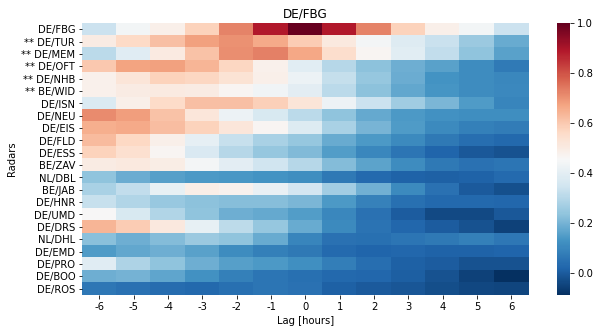

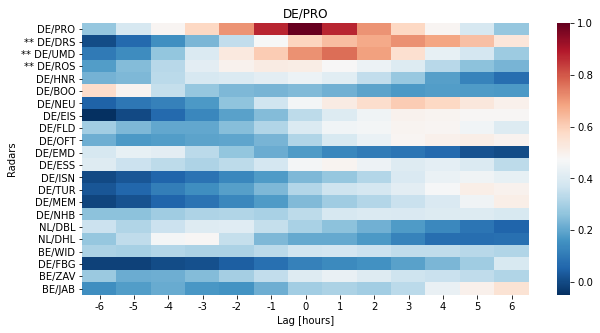

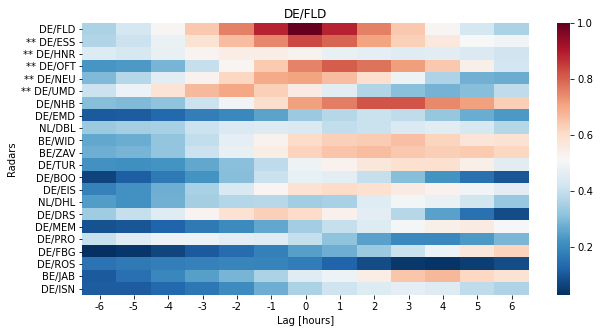

In [33]:
lags = range(-6,7)
spatio_temp_corr('DE/FBG', vid_data, names, lags=lags)
spatio_temp_corr('DE/PRO', vid_data, names, lags=lags)
spatio_temp_corr('DE/FLD', vid_data, names, lags=lags)

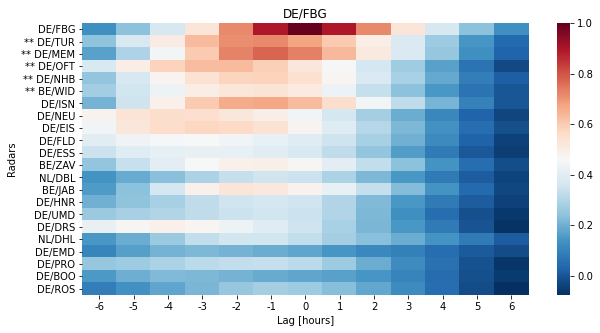

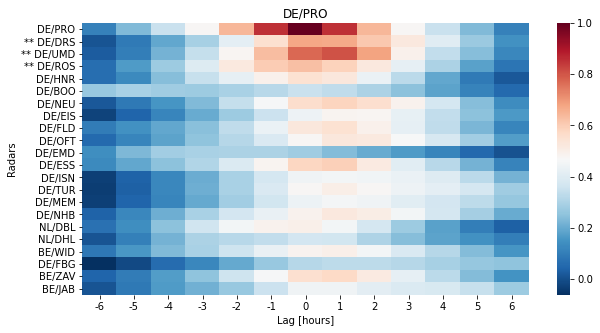

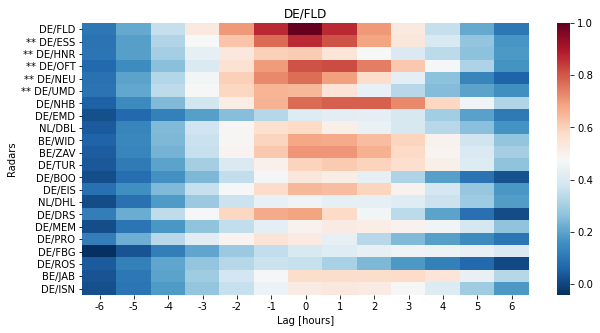

In [200]:
lags = range(-6,7)
spatio_temp_corr('DE/FBG', vid_data, names, lags=lags)
spatio_temp_corr('DE/PRO', vid_data, names, lags=lags)
spatio_temp_corr('DE/FLD', vid_data, names, lags=lags)

### Data Transformation to Normal Distribution

In [ ]:
data = all_data(vid_data).flatten()
data[np.where(data==0)] = np.nan
data = np.power(data, 0.133)
plt.hist(data, bins=20)

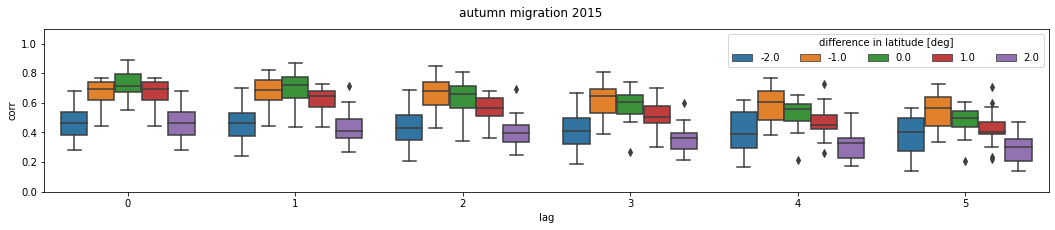

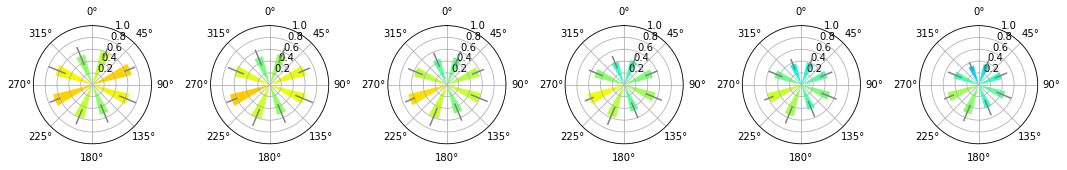

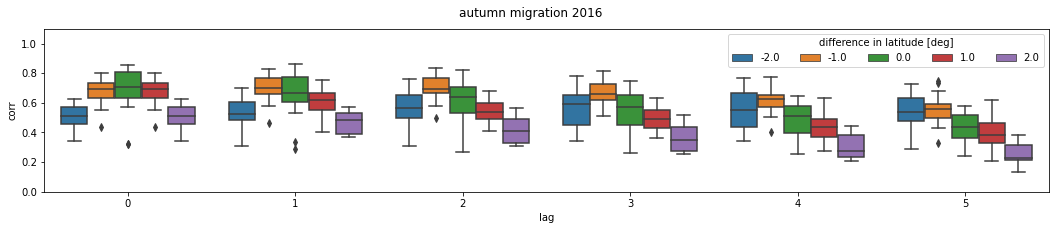

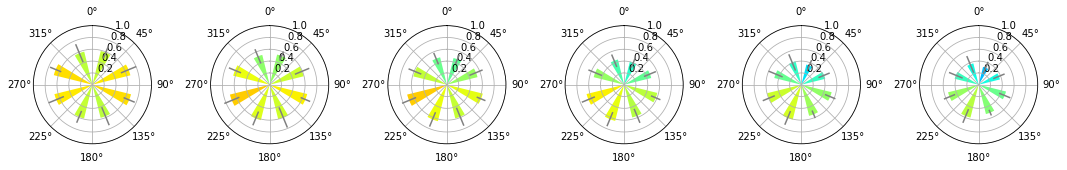

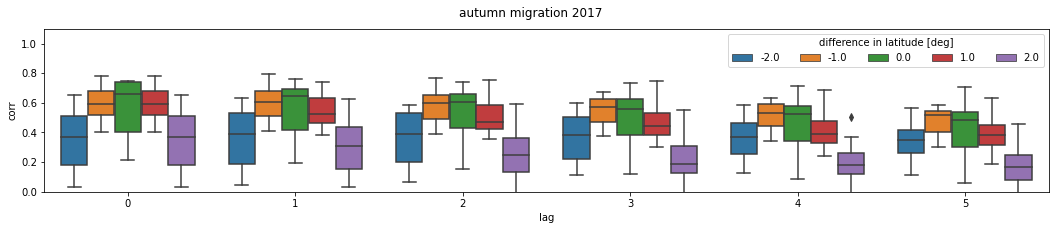

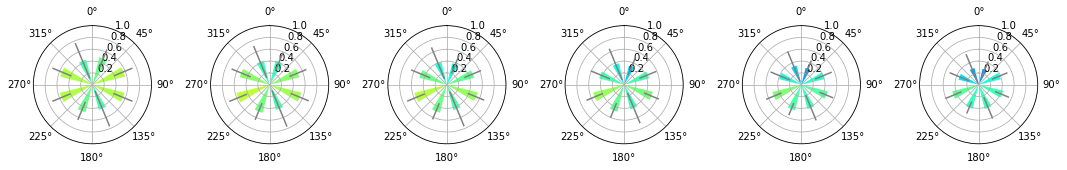

In [28]:
for y in years:
    corr_neighbours([vid_data[y]], [radars[y]], range(6), title=f'autumn migration {y}')

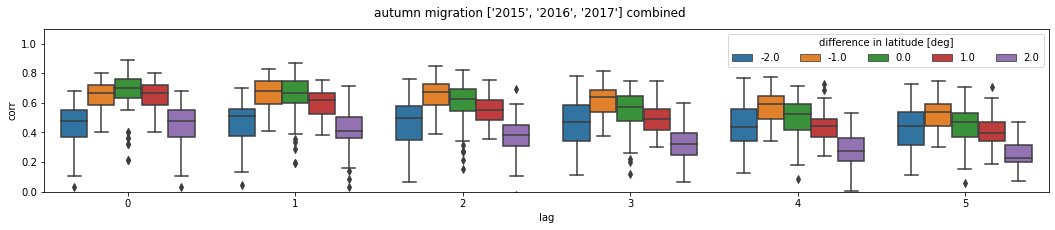

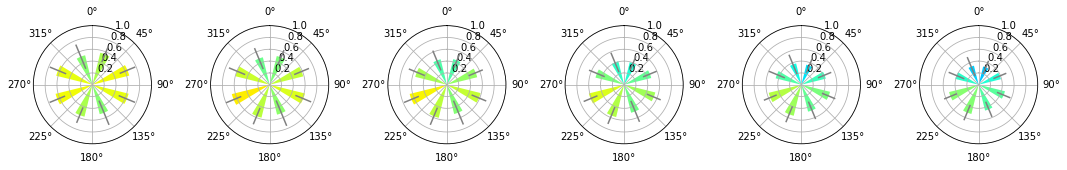

In [27]:
corr_neighbours([vid_data[y] for y in years], [radars[y] for y in years], range(6), title=f'autumn migration {years} combined')

In [31]:
# d = {a : f(a) for a in list}
def f(x):
    return 1
d = dict([(a, f(a)) for a in 'a b'.split()])
d
# d = dict(a = 1, b = 2)

{'a': 1, 'b': 1}

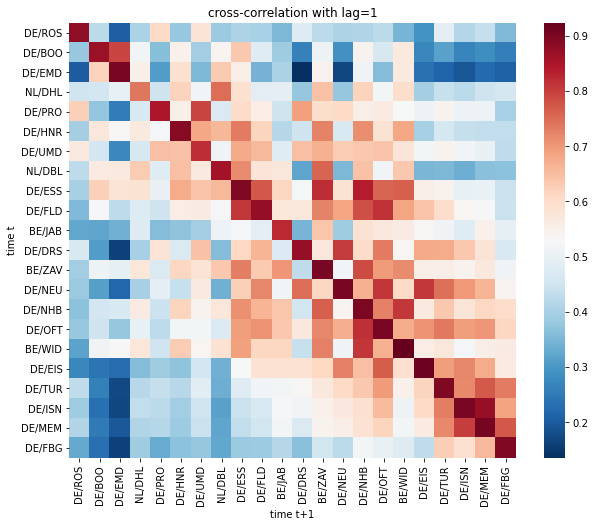

In [33]:
corr_matrix(vid_data_16, names_16)

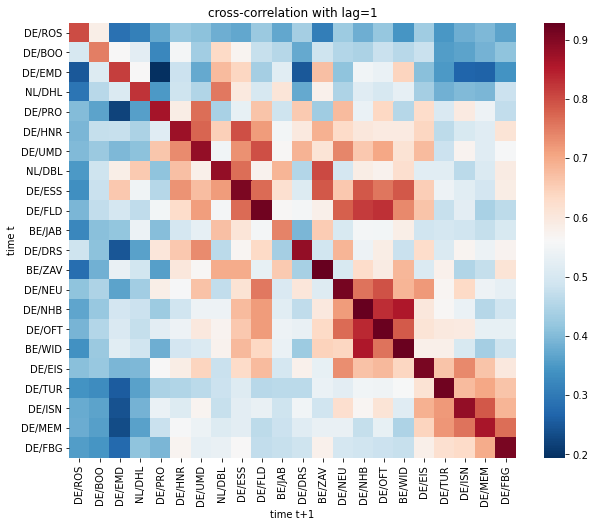

In [38]:
corr_matrix(vid_data_15, names_15)

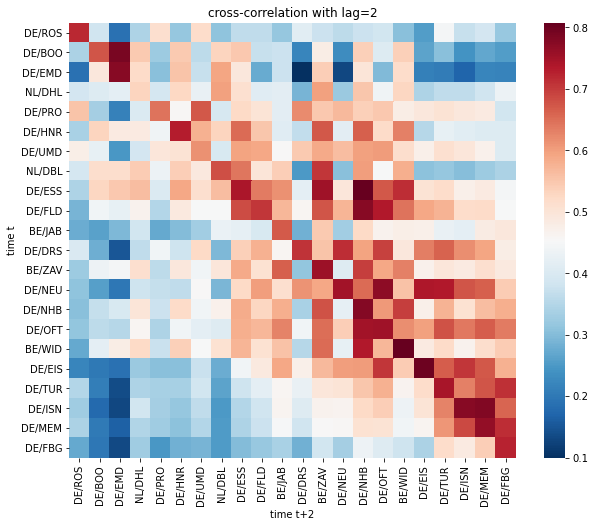

In [35]:
corr_matrix(vid_data_16, names_16, lag=2)

In [82]:
y = '2016'
data = vid_data[y]
names = radars[y]
spatial = Spatial(names)
adj, _ = spatial.voronoi()
mapping = {ci : idx for idx, ci in enumerate(names.keys())}
reverse_map = {idx : ci for ci, idx in mapping.items()}
T = len(t_range)
N = len(names)
d = np.zeros((N,T))

for ci, idx in mapping.items():
    d[idx, :] = arr(data[ci])

In [182]:
check = np.isfinite(d).all(axis=0)
X = np.zeros((N, 1))
Y = np.zeros((N, 1))
for t in range(T-1):
    if check[t] and check[t+1]:
        X = np.concatenate((X, d[:, t][..., np.newaxis]), axis=1)
        Y = np.concatenate((Y, d[:, t+1][..., np.newaxis]), axis=1)
X = X[:,1:]
Y = Y[:,1:]

In [78]:
def train_test_split(X, y, target_idx, neighbours):
    # Split the data into training/testing sets
    X_train = X[neighbours, 200:].T
    X_test = X[neighbours, :200].T

    # Split the targets into training/testing sets
    y_train = Y[target_idx, 200:]
    y_test = Y[target_idx, :200]
    
    return X_train, y_train, X_test, y_test


Target radar:  DE/MEM
Coefficients: 
 [('DE/ISN', 0.5195755147856614), ('DE/TUR', 0.21219764745724157), ('DE/FBG', -0.23749426929423034), ('DE/MEM', 0.6199315764761866)]
Sum of coefficients:  1.1142104694248594
Mean squared error: 36.23
Coefficient of determination: 0.74


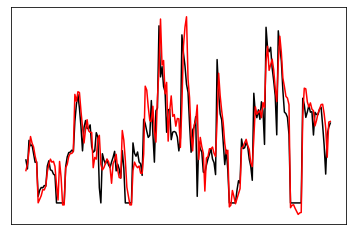

Target radar:  DE/ISN
Coefficients: 
 [('DE/MEM', -0.07810277387808998), ('DE/TUR', -0.019860542507545653), ('DE/EIS', 0.18384391821077398), ('DE/ISN', 0.8852676562652217)]
Sum of coefficients:  0.9711482580903601
Mean squared error: 25.03
Coefficient of determination: 0.75


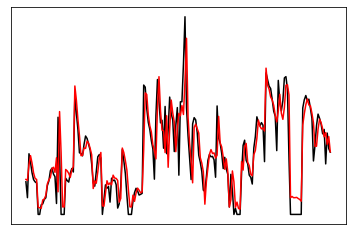

Target radar:  DE/ESS
Coefficients: 
 [('DE/OFT', 0.08361454174802924), ('BE/ZAV', -0.11996647561906348), ('DE/NHB', -0.2950701621255941), ('DE/HNR', 0.2177045682113927), ('DE/FLD', 0.21785811412846043), ('DE/EMD', 0.016195547494985973), ('NL/DBL', 0.33493683287544584), ('DE/ESS', 0.6050017919716054)]
Sum of coefficients:  1.060274758685262
Mean squared error: 34.81
Coefficient of determination: 0.64


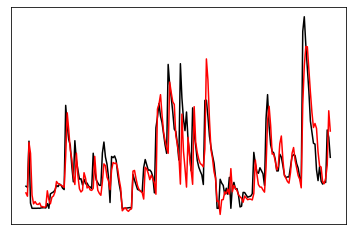

Target radar:  DE/PRO
Coefficients: 
 [('DE/UMD', -0.03561078956608203), ('DE/ROS', 0.22620623702233555), ('DE/DRS', -0.027423645566836963), ('DE/PRO', 0.8616038489536137)]
Sum of coefficients:  1.0247756508430304
Mean squared error: 39.54
Coefficient of determination: 0.57


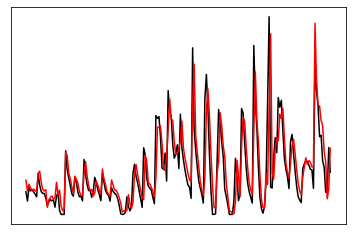

Target radar:  DE/OFT
Coefficients: 
 [('DE/ESS', 0.04538764382131743), ('DE/TUR', -0.010079231696620838), ('DE/FBG', -0.033785264655125345), ('DE/NEU', 0.12891413989250808), ('DE/NHB', -0.09064354300366649), ('DE/FLD', 0.07210197417896724), ('DE/OFT', 0.7059371979848883)]
Sum of coefficients:  0.8178329165222684
Mean squared error: 4.79
Coefficient of determination: 0.74


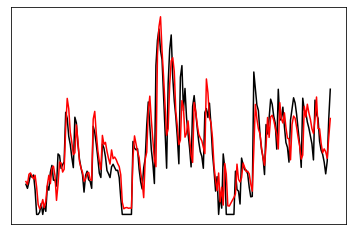

Target radar:  DE/TUR
Coefficients: 
 [('DE/MEM', -0.06753950204577754), ('DE/ISN', 0.14230957117254212), ('DE/OFT', 0.04215268693298436), ('DE/EIS', -0.10532564172550812), ('DE/FBG', -0.01381434864534442), ('DE/NEU', 0.2907829014705189), ('DE/TUR', 0.7515253920060804)]
Sum of coefficients:  1.0400910591654957
Mean squared error: 21.94
Coefficient of determination: 0.76


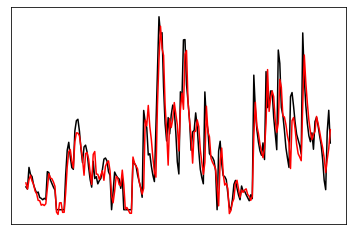

Target radar:  DE/UMD
Coefficients: 
 [('DE/PRO', 0.5894419928761454), ('DE/NEU', -0.048763482287391136), ('DE/HNR', 0.29059114500095184), ('DE/ROS', 0.07008764212069026), ('DE/FLD', -0.03247168091596872), ('DE/BOO', -0.16974478033280443), ('DE/DRS', 0.05541521942408445), ('DE/UMD', 0.1759672393057543)]
Sum of coefficients:  0.9305232951914619
Mean squared error: 57.95
Coefficient of determination: 0.58


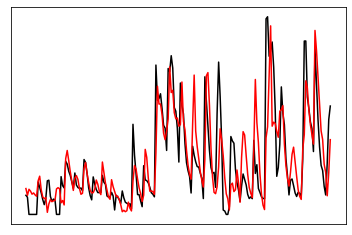

Target radar:  BE/ZAV
Coefficients: 
 [('DE/ESS', 0.06119613235433262), ('DE/NHB', -0.04367433687538386), ('BE/WID', -7.002925948274702e-05), ('BE/JAB', 0.04427417723323879), ('NL/DBL', 0.17454127512357306), ('BE/ZAV', 0.663448931094291)]
Sum of coefficients:  0.8997161496705689
Mean squared error: 3.73
Coefficient of determination: 0.62


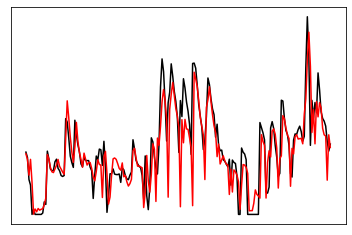

Target radar:  DE/EIS
Coefficients: 
 [('DE/ISN', -0.11841112878612002), ('DE/TUR', -0.04653600413685077), ('DE/NEU', 0.17788733013548008), ('DE/DRS', 0.07875352623875295), ('DE/EIS', 0.840067884300275)]
Sum of coefficients:  0.9317616077515373
Mean squared error: 8.77
Coefficient of determination: 0.73


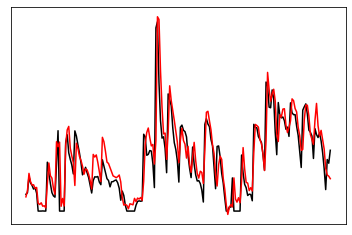

Target radar:  DE/FBG
Coefficients: 
 [('DE/MEM', 0.14480497928152522), ('DE/OFT', 0.08056971753176095), ('DE/TUR', 0.0664051489972321), ('DE/NHB', 0.046357452831027296), ('BE/WID', -0.029867211143157713), ('DE/FBG', 0.6712192625209212)]
Sum of coefficients:  0.9794893500193091
Mean squared error: 19.44
Coefficient of determination: 0.78


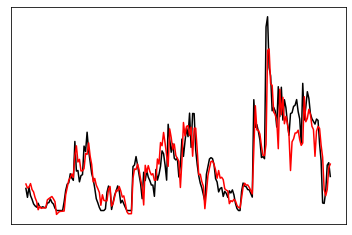

Target radar:  DE/NEU
Coefficients: 
 [('DE/OFT', -0.12934798047666488), ('DE/TUR', -0.035270797041856594), ('DE/UMD', 0.0694885736874852), ('DE/EIS', -0.02274093083629418), ('DE/FLD', 0.03348712223800891), ('DE/DRS', 0.19763213661641033), ('DE/NEU', 0.7256469223931836)]
Sum of coefficients:  0.8388950465802725
Mean squared error: 18.18
Coefficient of determination: 0.71


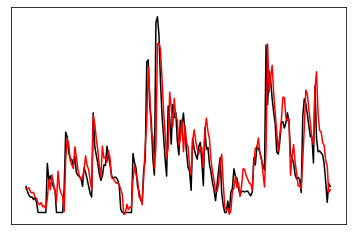

Target radar:  DE/NHB
Coefficients: 
 [('DE/ESS', 0.21006347076272394), ('DE/OFT', 0.4035687872391903), ('BE/ZAV', -0.07406630342926587), ('DE/FBG', -0.10256617397197051), ('BE/WID', 0.04060613003833097), ('DE/NHB', 0.5000463900258632)]
Sum of coefficients:  0.9776523006648719
Mean squared error: 22.84
Coefficient of determination: 0.78


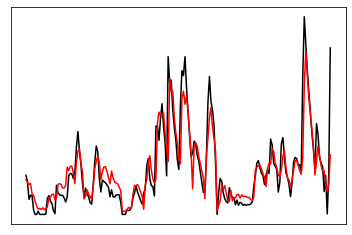

Target radar:  DE/HNR
Coefficients: 
 [('DE/ESS', -0.08678917329679209), ('DE/UMD', 0.09120835074857814), ('DE/FLD', 0.013041348998721503), ('DE/BOO', 0.0661291433894103), ('DE/EMD', 0.20219103786056242), ('DE/HNR', 0.7990120927032214)]
Sum of coefficients:  1.0847928004037017
Mean squared error: 38.36
Coefficient of determination: 0.80


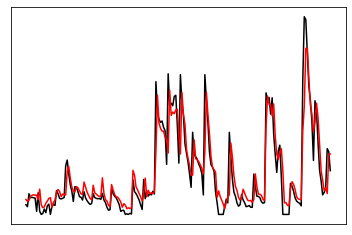

Target radar:  DE/ROS
Coefficients: 
 [('DE/PRO', 0.010343065443998307), ('DE/UMD', 0.01681140879816706), ('DE/BOO', -0.0010563297863709856), ('DE/ROS', 0.7728920127006644)]
Sum of coefficients:  0.7989901571564588
Mean squared error: 9.90
Coefficient of determination: 0.72


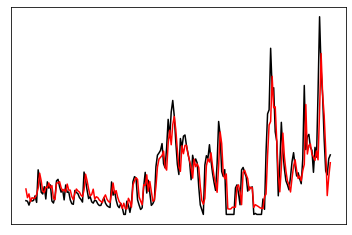

Target radar:  BE/WID
Coefficients: 
 [('BE/ZAV', 0.010905778389004821), ('DE/FBG', -0.20183287075023226), ('DE/NHB', 0.11843237386009492), ('BE/WID', 0.931276640352987)]
Sum of coefficients:  0.8587819218518544
Mean squared error: 53.06
Coefficient of determination: 0.78


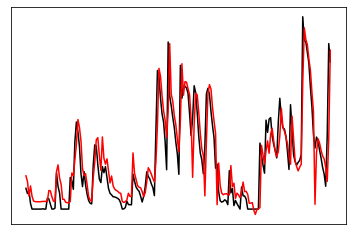

Target radar:  BE/JAB
Coefficients: 
 [('BE/ZAV', 0.6544511300566328), ('NL/DBL', -0.22477476432490082), ('NL/DHL', 0.07761750176243652), ('BE/JAB', 0.5804088806547335)]
Sum of coefficients:  1.087702748148902
Mean squared error: 7.18
Coefficient of determination: 0.07


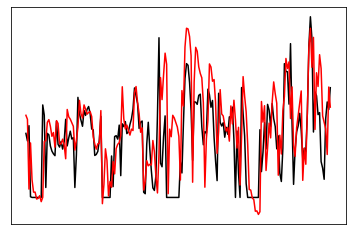

Target radar:  DE/FLD
Coefficients: 
 [('DE/ESS', -0.06195696546954279), ('DE/OFT', -0.4221106508751572), ('DE/UMD', 0.18567997114274742), ('DE/NEU', 0.3297897262006187), ('DE/HNR', 0.14662480345125284), ('DE/FLD', 0.7879826843174859)]
Sum of coefficients:  0.9660095687674048
Mean squared error: 52.84
Coefficient of determination: 0.62


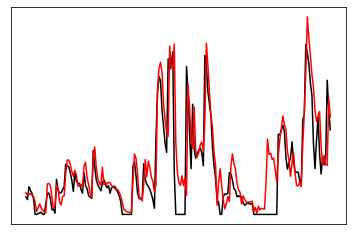

Target radar:  DE/BOO
Coefficients: 
 [('DE/UMD', -0.00238765705136942), ('DE/HNR', 0.0867729785629967), ('DE/ROS', -0.04070105795685372), ('DE/EMD', -0.10216598821293071), ('DE/BOO', 0.9366722560571644)]
Sum of coefficients:  0.8781905313990073
Mean squared error: 7.39
Coefficient of determination: 0.60


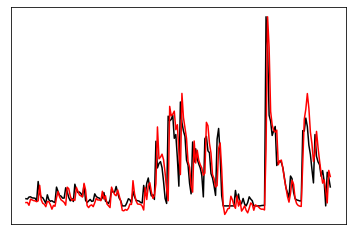

Target radar:  DE/EMD
Coefficients: 
 [('DE/ESS', -0.036173812280544185), ('DE/HNR', -0.04181436149241591), ('DE/BOO', 0.9364055658894983), ('NL/DBL', 0.08565883354618442), ('NL/DHL', 0.11550418007291655), ('DE/EMD', 0.5469985557577943)]
Sum of coefficients:  1.6065789614934336
Mean squared error: 17.03
Coefficient of determination: -5.54


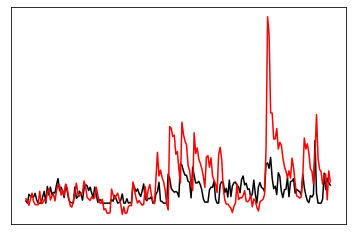

Target radar:  DE/DRS
Coefficients: 
 [('DE/PRO', 0.19473095173001603), ('DE/UMD', -0.009224004346735204), ('DE/EIS', -0.10281857805155674), ('DE/NEU', 0.1204671375666932), ('DE/DRS', 0.8047545932189897)]
Sum of coefficients:  1.007910100117407
Mean squared error: 65.58
Coefficient of determination: 0.66


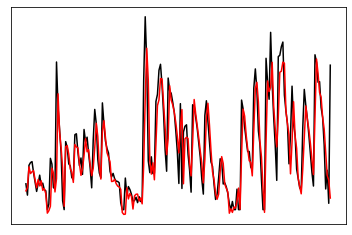

Target radar:  NL/DBL
Coefficients: 
 [('DE/ESS', 0.04337774710957067), ('BE/ZAV', -0.17792997628067503), ('BE/JAB', -0.006134974273002362), ('DE/EMD', 0.0805262822785974), ('NL/DHL', 0.30767041405741863), ('NL/DBL', 0.5285974616346367)]
Sum of coefficients:  0.776106954526546
Mean squared error: 5.57
Coefficient of determination: 0.65


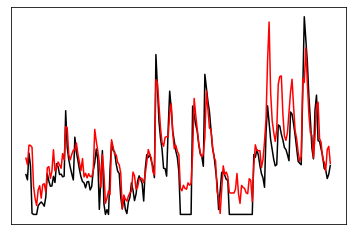

Target radar:  NL/DHL
Coefficients: 
 [('BE/JAB', 0.06882561600200121), ('DE/EMD', 0.17327988677675), ('NL/DBL', -0.11748042092377828), ('NL/DHL', 0.5344036469347566)]
Sum of coefficients:  0.6590287287897295
Mean squared error: 16.97
Coefficient of determination: 0.56


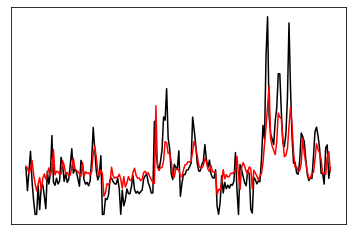

In [90]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

for idx in range(N):
    
    reg = linear_model.LinearRegression()

    neighbours = np.concatenate((np.where(adj[idx]>0)[0], [idx]))
    X_train, y_train, X_test, y_test = train_test_split(X, Y, idx, neighbours)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    print('Target radar: ', names[reverse_map[idx]])
    print('Coefficients: \n', [(names[reverse_map[j]], reg.coef_[i]) for i, j in enumerate(neighbours)])
    print('Sum of coefficients: ', reg.coef_.sum())
    print('Mean squared error: %.2f'
          % mean_squared_error(y_test, y_pred))
    print('Coefficient of determination: %.2f'
          % r2_score(y_test, y_pred))

    # Plot outputs
    plt.plot(y_test,  color='black')
    plt.plot(y_pred, color='red')

    plt.xticks(())
    plt.yticks(())

    plt.show()

In [150]:
from scipy.optimize import minimize

idx = 3
neighbours = np.concatenate((np.where(adj[idx]>0)[0], [idx]))
X_train, y_train, X_test, y_test = train_test_split(X, Y, idx, neighbours)

def loss(w, X_train, y_train):
    
    return np.square(y_train - w.T.dot(X_train.T)).sum()
    
def loss_der(w, X_train, y_train):

    s = y_train - w.T.dot(X_train.T)
    der = -2 * s.T.dot(X_train)

    return der

ineq_cons = {'type': 'ineq',
             'fun' : lambda x: x,
             'jac' : lambda x: np.eye(x.size)}

from scipy.optimize import Bounds



In [318]:

def loss_all(w, X_train, Y_train, adj, targets, sources=None):
    
    i = 0
    loss = 0
    for idx in targets:
        neighbours = np.where(adj[idx])[0]
        X = X_train[:,neighbours]
        y = Y_train[idx]
        nn = neighbours.size
        
        if sources is not None:
            w0 = 1 - w[np.where(sources==idx)].sum()
            x0 = X_train[:, idx]
            loss += np.square(y - w[i:i+nn].T.dot(X.T) - w0*x0).sum()
        else:
            loss += np.square(y - w[i:i+nn].T.dot(X.T)).sum()
            
        i += nn
    return loss
    
def loss_der_all(w, X_train, Y_train, adj, targets, sources=None):
    der_list = []
    i = 0
    for idx in targets:
        neighbours = np.where(adj[idx])[0]
        X = X_train[:,neighbours]
        y = Y_train[idx]
        nn = neighbours.size
        
        if sources is not None:
            w0 = 1 - w[np.where(sources==idx)].sum()
            x0 = X_train[:, idx]
            s = y - w[i:i+nn].T.dot(X.T) - w0*x0
        else:
            s = y - w[i:i+nn].T.dot(X.T)
        der_list.append(-2 * s.T.dot(X))
        i += nn
    der = np.concatenate(tuple(der_list), axis=0)
    return der

In [358]:
def run_optimization(X_train, Y_train, edges, force_conservation=True, init='static', constraints=True, ftol=0.001, maxiter=200):
    if not force_conservation:
        edges = edges + np.eye(N, dtype=int)
        
    boundary = ['DE/ROS', 'DE/PRO', 'DE/DRS', 'DE/EIS', 'DE/ISN', 'DE/MEM', 'DE/FBG', 
                'BE/WID', 'BE/ZAV', 'BE/JAB', 'NL/DHL']
    targets = [i for i in range(N) if names[reverse_map[i]] not in boundary]
    sources = np.concatenate([np.where(edges[idx])[0] for idx in targets])
    
    if init == 'static':
        x0 = np.concatenate([np.where(edges[idx])[0] == idx for idx in targets])
    else:
        x0 = np.random.rand(sources.size)

    if force_conservation:
        cons_type = 'ineq'
    else:
        cons_type = 'eq'
    cons = {'type': cons_type,
                 'fun' : lambda x: np.array([1-x[np.where(sources==i)[0]].sum() for i in targets])}#,
                 #'jac' : lambda x: np.array([[source==i for source in sources] for i in range(N)])}

    method = 'SLSQP'
    bounds = Bounds(0, 1)

    def callback(xk):
        print(cons['fun'](xk))
    #method = 'L-BFGS-B'
    #method = 'TNC'
    #method = 'trust-constr'
    if constraints:
        res = minimize(loss_all, x0, args=(X_train, Y_train, edges, targets, (sources if force_conservation else None)), bounds=bounds, method=method, 
                       constraints=cons, 
                       jac=loss_der_all,  options={'ftol': ftol, 'disp': True, 'maxiter':maxiter})#, callback = callback)
    else:
        res = minimize(loss_all, x0, args=(X_train, Y_train, edges, targets, (sources if force_conservation else None)), bounds=bounds, method=method, 
                       jac=loss_der_all,  options={'ftol': ftol, 'disp': True, 'maxiter':maxiter})#, callback = callback)
    
    return res, sources, targets, edges


### Force bird conservation

In [339]:
res, sources, targets, scale, X_train, Y_train, X_test, Y_test = run_optimization(force_conservation=True, init='static', constraints=True)
for idx in targets:A
    out_flux = res.x[np.where(sources==idx)].sum()
    print(f'{names[reverse_map[idx]]}: out-flux = {out_flux}, w_ii = {1-out_flux}')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3141.701524535717
            Iterations: 5
            Function evaluations: 23
            Gradient evaluations: 5
DE/ESS: out-flux = 0.018897373794074267, w_ii = 0.9811026262059257
DE/OFT: out-flux = 0.010290207461253139, w_ii = 0.9897097925387469
DE/TUR: out-flux = 5.819824074343038e-10, w_ii = 0.9999999994180175
DE/UMD: out-flux = 0.08557049187796179, w_ii = 0.9144295081220382
DE/NEU: out-flux = 0.010290207281205999, w_ii = 0.989709792718794
DE/NHB: out-flux = 1.627531180420182e-09, w_ii = 0.9999999983724688
DE/HNR: out-flux = 0.047375207513414154, w_ii = 0.9526247924865858
DE/FLD: out-flux = 3.1163223958638407e-09, w_ii = 0.9999999968836776
DE/BOO: out-flux = 0.20712995995467692, w_ii = 0.792870040045323
DE/EMD: out-flux = 0.20712997446130976, w_ii = 0.7928700255386902
NL/DBL: out-flux = 0.058985796135394994, w_ii = 0.941014203864605


In [342]:
res, sources, targets, scale, X_train, Y_train, X_test, Y_test = run_optimization(force_conservation=True, init='static', constraints=False)
for idx in targets:
    out_flux = res.x[np.where(sources==idx)].sum()
    print(f'{names[reverse_map[idx]]}: out-flux = {out_flux}, w_ii = {1-out_flux}')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3136.484377958477
            Iterations: 6
            Function evaluations: 27
            Gradient evaluations: 6
DE/ESS: out-flux = 0.03551384391691621, w_ii = 0.9644861560830837
DE/OFT: out-flux = 0.009189191402207596, w_ii = 0.9908108085977924
DE/TUR: out-flux = 1.0052702077985241e-10, w_ii = 0.999999999899473
DE/UMD: out-flux = 0.09683826724394777, w_ii = 0.9031617327560523
DE/NEU: out-flux = 0.009189191373065193, w_ii = 0.9908108086269348
DE/NHB: out-flux = 2.811767861540207e-10, w_ii = 0.9999999997188233
DE/HNR: out-flux = 0.065391202279759, w_ii = 0.934608797720241
DE/FLD: out-flux = 5.384667937546884e-10, w_ii = 0.9999999994615332
DE/BOO: out-flux = 0.2531235602369516, w_ii = 0.7468764397630484
DE/EMD: out-flux = 0.23070571029187398, w_ii = 0.7692942897081261
NL/DBL: out-flux = 0.0993817613702195, w_ii = 0.9006182386297805


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2992.709132139758
            Iterations: 60
            Function evaluations: 152
            Gradient evaluations: 60
DE/ESS: total flux = 1.0000000018640292, 
 weights = [7.45222420e-01 2.06760721e-10 9.65022297e-02 1.22711090e-09
 9.19288654e-02 5.19655310e-04 6.58268298e-02]
DE/OFT: total flux = 1.0000000007939056, 
 weights = [7.76509508e-02 7.08520913e-01 8.83157235e-02 2.48979157e-10
 1.19847824e-01 5.66458950e-03]
DE/TUR: total flux = 1.0, 
 weights = [0.08074568 0.84527183 0.07398248]
DE/UMD: total flux = 1.0000000000000002, 
 weights = [0.67592273 0.04348892 0.13645544 0.08958698 0.05454592]
DE/NEU: total flux = 1.000000002622578, 
 weights = [9.68994881e-11 1.20154817e-01 6.00977010e-09 7.95382393e-01
 8.44627862e-02]
DE/NHB: total flux = 1.0, 
 weights = [0.03173306 0.10327344 0.8649935 ]
DE/HNR: total flux = 1.0000000009671433, 
 weights = [4.04014323e-02 1.09176320e-01 8.17167105e-

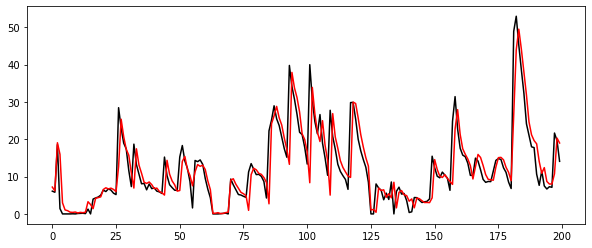

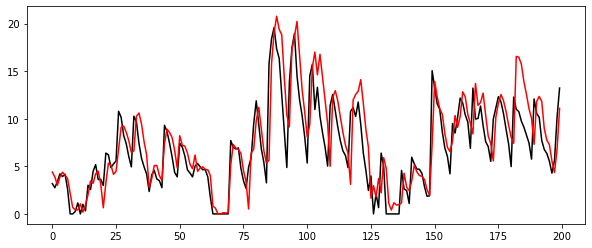

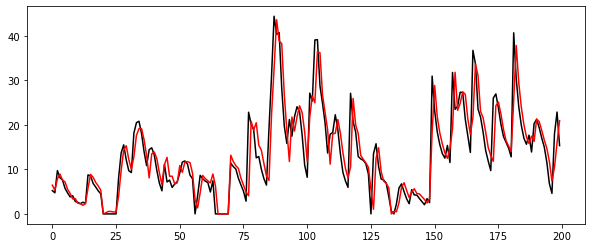

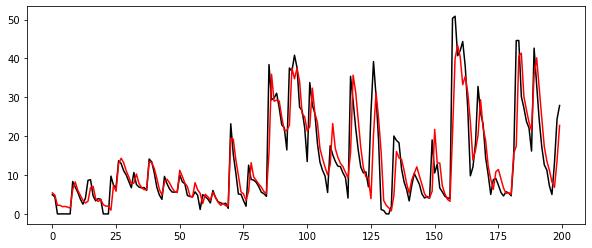

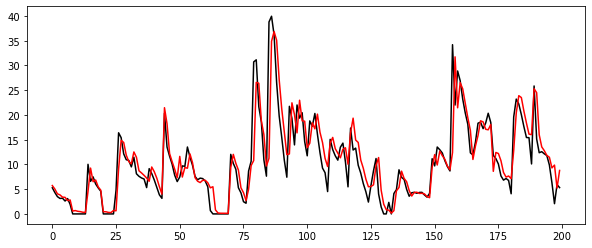

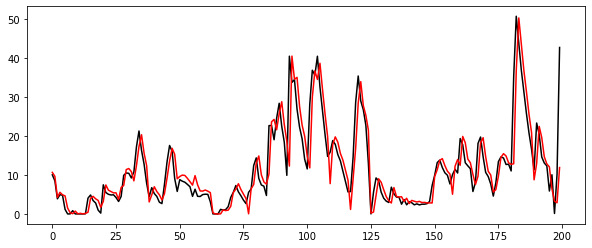

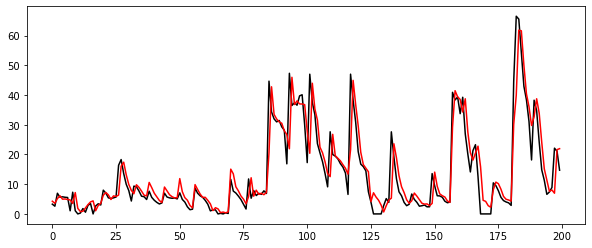

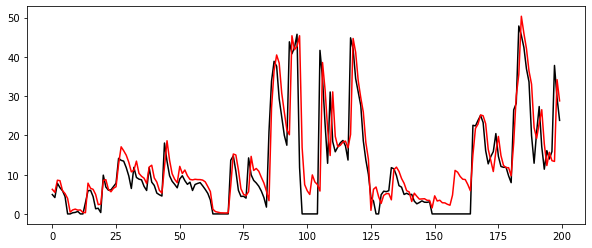

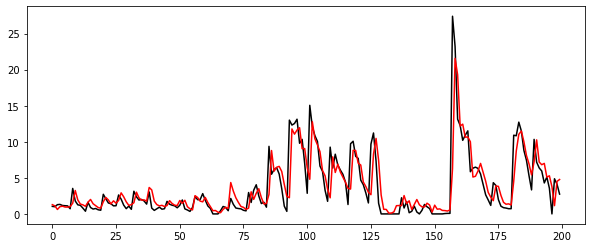

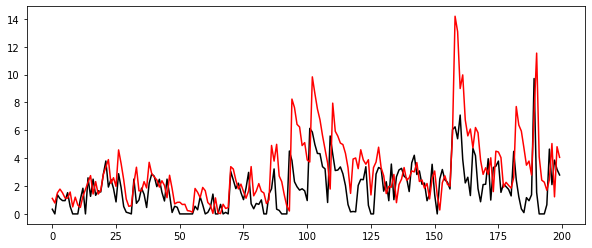

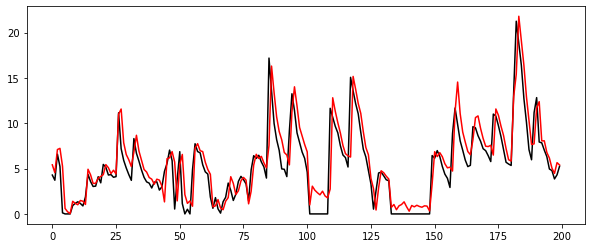

In [365]:
y = '2016'
data = vid_data[y]
names = radars[y]
spatial = Spatial(names)
adj, _ = spatial.voronoi()
mapping = {ci : idx for idx, ci in enumerate(names.keys())}
reverse_map = {idx : ci for ci, idx in mapping.items()}
T = len(t_range)
N = len(names)
d = np.zeros((N,T))

for ci, idx in mapping.items():
    d[idx, :] = arr(data[ci])
    
check = np.isfinite(d).all(axis=0)
X = np.zeros((N, 1))
Y = np.zeros((N, 1))
for t in range(T-1):
    if np.all(check[t:t+2]):
        X = np.concatenate((X, d[:, t][..., np.newaxis]), axis=1)
        Y = np.concatenate((Y, d[:, t+1][..., np.newaxis]), axis=1)
X = X[:,1:]
Y = Y[:,1:]

scale = X.max(axis=0) * 0.2
X /= scale
Y /= scale

X_train = X[:, 200:].T
Y_train = Y[:, 200:]

X_test = X[:, :200].T
Y_test = Y[:, :200]

edges = (adj > 0)

res, sources, targets, edges = run_optimization(X_train, Y_train, edges, force_conservation=False, init='static', constraints=True)
for idx in targets:
    out_flux = res.x[np.where(sources==idx)].sum()
    print(f'{names[reverse_map[idx]]}: total flux = {out_flux}, \n weights = {res.x[np.where(sources==idx)]}')
    
i = 0
for idx in targets:
    neighbours = np.where(edges[idx])[0]
    nn = neighbours.size
    X = X_test[:,neighbours]
    y = Y_test[idx]
    y_pred = res.x[i:i+nn].T.dot(X.T)
    print(res.x[i:i+nn])
    i += nn
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(y*scale[:200], color='black')
    ax.plot(y_pred*scale[:200], color='red')

In [345]:
res, sources, targets, scale, X_train, Y_train, X_test, Y_test = run_optimization(force_conservation=False, init='static', constraints=False)
for idx in targets:
    out_flux = res.x[np.where(sources==idx)].sum()
    print(f'{names[reverse_map[idx]]}: total flux = {out_flux}, weights = {res.x[np.where(sources==idx)]}')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2859.9300637497363
            Iterations: 70
            Function evaluations: 182
            Gradient evaluations: 70
DE/ESS: total flux = 0.9464870941453537, weights = [7.07203573e-01 7.55820044e-03 1.58101478e-01 5.02539407e-09
 5.61420351e-02 2.95250112e-09 1.74817995e-02]
DE/OFT: total flux = 1.0496558972932304, weights = [7.01611776e-02 7.52060476e-01 1.52702344e-02 9.94503982e-10
 2.12164007e-01 4.64740162e-10]
DE/TUR: total flux = 0.8998081010970235, weights = [0.06135535 0.8224896  0.01596315]
DE/UMD: total flux = 0.750189037071027, weights = [5.70964921e-01 2.19979289e-02 9.14711885e-02 6.57549984e-02
 6.42839269e-10]
DE/NEU: total flux = 1.074424588071308, weights = [4.12850339e-02 1.55583836e-01 9.78468247e-10 7.61375566e-01
 1.16180151e-01]
DE/NHB: total flux = 0.5776785362458142, weights = [4.69041008e-09 3.18798107e-09 5.77678528e-01]
DE/HNR: total flux = 1.183061115804944, weigh

[6.38483927e-13 8.64663409e-13 2.79854357e-12 1.64397885e-02
 1.77584453e-12 9.11726489e-02 2.56881258e-02]


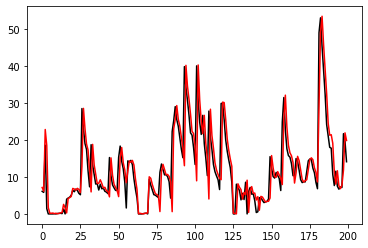

[9.98785586e-13 2.48710080e-05 1.48689462e-12 2.80226140e-05
 1.71876893e-12 8.67679990e-13]


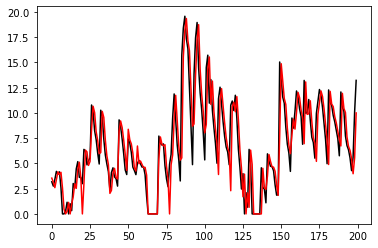

[2.17103472e-12 1.38552454e-12 6.40305009e-13 7.50266721e-13
 2.19507151e-12 1.58556873e-02]


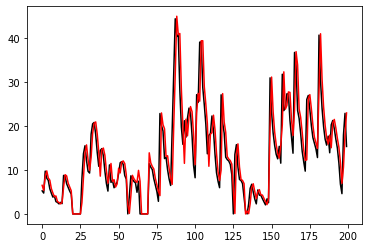

[7.95837191e-02 1.17886667e-12 1.85893098e-02 3.27903043e-13
 2.18733077e-12 2.89203071e-02 1.14123738e-12]


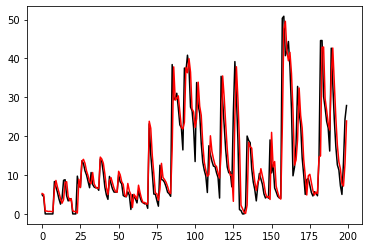

[8.23578332e-13 9.93311621e-13 6.09181551e-07 9.38483772e-13
 1.44453548e-12 3.41205527e-05]


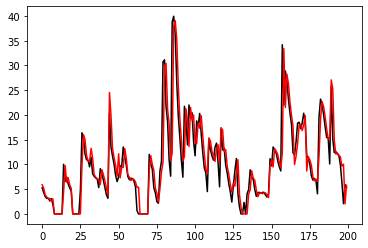

[2.72106576e-02 1.15005668e-02 5.95083141e-13 1.50635318e-12
 6.53124712e-03]


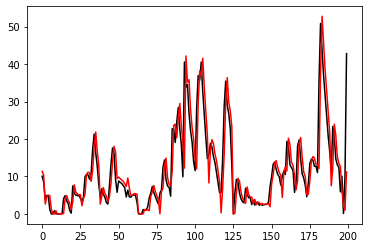

[2.58815401e-12 5.76651183e-02 2.62265291e-12 3.85005194e-02
 9.91223527e-02]


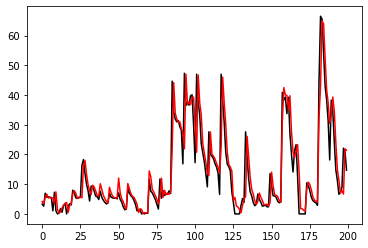

[1.30459990e-12 8.97711902e-13 2.83201910e-02 6.53124712e-03
 6.53124712e-03]


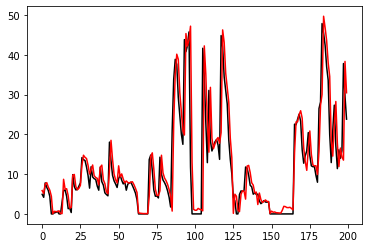

[0.01245905 0.03059713 0.10971835 0.05572629]


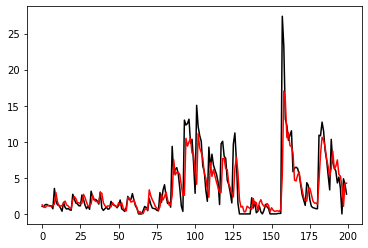

[1.31825313e-12 1.72196637e-12 4.36277373e-01 4.12662988e-02
 2.25179505e-02]


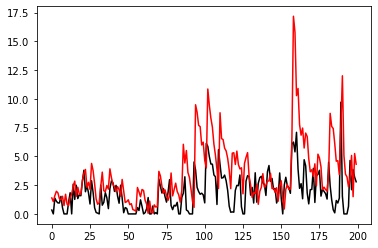

[9.16620684e-13 7.83828815e-13 5.85827223e-13 6.76855908e-02
 8.00390806e-02]


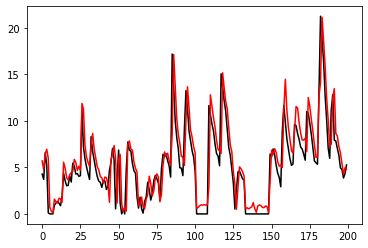

In [294]:
i = 0
for idx in targets:
    neighbours = np.where(edges[idx])[0]
    nn = neighbours.size
    X = X_test[:,neighbours]
    y = Y_test[idx]
    w0 = 1 - res.x[np.where(sources==idx)].sum()
    x0 = X_test[:, idx]
    y_pred = res.x[i:i+nn].T.dot(X.T) + w0*x0
    print(res.x[i:i+nn])
    i += nn
    plt.plot(y*scale[:200], color='black')
    plt.plot(y_pred*scale[:200], color='red')
    plt.show()
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 38256.91616911061
            Iterations: 20
            Function evaluations: 65
            Gradient evaluations: 16
Target radar:  DE/MEM
Coefficients: 
 [('DE/ISN', 0.5341343679909655), ('DE/TUR', 0.15588433689307157), ('DE/FBG', 0.0019036482374191444), ('DE/MEM', 0.5177382894797573)]
Mean squared error: 7659.81


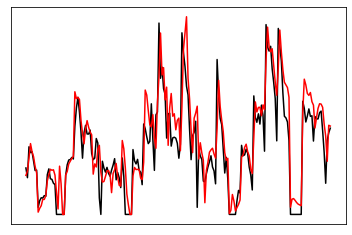

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 16055.784773524018
            Iterations: 19
            Function evaluations: 62
            Gradient evaluations: 15
Target radar:  DE/ISN
Coefficients: 
 [('DE/MEM', 0.0), ('DE/TUR', 0.0), ('DE/EIS', 0.16848328672317525), ('DE/ISN', 0.8293177563031693)]
Mean squared error: 4716.44


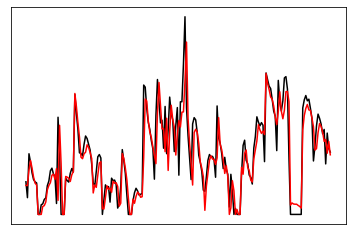

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 48133.53986697759
            Iterations: 25
            Function evaluations: 75
            Gradient evaluations: 21
Target radar:  DE/ESS
Coefficients: 
 [('DE/OFT', 3.6781157693016935e-05), ('BE/ZAV', 2.619851383274217e-05), ('DE/NHB', 0.00010943200793157779), ('DE/HNR', 0.1852562050193447), ('DE/FLD', 0.17261513306246126), ('DE/EMD', 0.00020035802491631593), ('NL/DBL', 0.16537361591143346), ('DE/ESS', 0.5314259481776549)]
Mean squared error: 6656.87


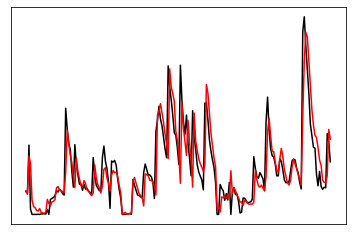

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 28990.343537094977
            Iterations: 15
            Function evaluations: 23
            Gradient evaluations: 11
Target radar:  DE/PRO
Coefficients: 
 [('DE/UMD', 0.0), ('DE/ROS', 0.23497975179328853), ('DE/DRS', 1.0183370527136585e-06), ('DE/PRO', 0.8205627070759589)]
Mean squared error: 7676.22


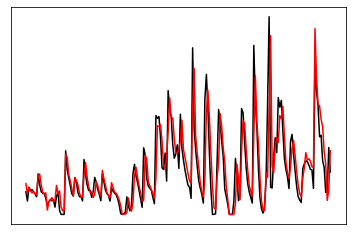

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9138.884574728125
            Iterations: 19
            Function evaluations: 36
            Gradient evaluations: 15
Target radar:  DE/OFT
Coefficients: 
 [('DE/ESS', 0.008096343064807386), ('DE/TUR', 4.102887427128408e-08), ('DE/FBG', 7.485388218390005e-08), ('DE/NEU', 0.13210940606203558), ('DE/NHB', 8.804599705349874e-08), ('DE/FLD', 0.08175266621413832), ('DE/OFT', 0.605369132031573)]
Mean squared error: 1021.29


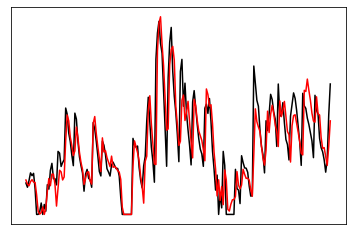

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 18431.79432484074
            Iterations: 21
            Function evaluations: 54
            Gradient evaluations: 17
Target radar:  DE/TUR
Coefficients: 
 [('DE/MEM', 3.370673485837185e-08), ('DE/ISN', 0.02789985475120779), ('DE/OFT', 1.5323302251020418e-05), ('DE/EIS', 3.512982015917543e-08), ('DE/FBG', 1.7748604622058725e-08), ('DE/NEU', 0.23604112723458945), ('DE/TUR', 0.7190834473178815)]
Mean squared error: 4122.43


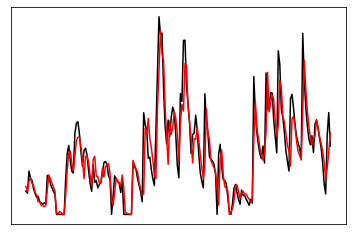

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 86928.67442566215
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Target radar:  DE/UMD
Coefficients: 
 [('DE/PRO', 0.20470556644012117), ('DE/NEU', 0.09424791928740454), ('DE/HNR', 0.2255319783865923), ('DE/ROS', 0.04988224310040992), ('DE/FLD', 0.16097110409650808), ('DE/BOO', 0.029952612858653267), ('DE/DRS', 0.13310582148240416), ('DE/UMD', 0.19254522852770659)]
Mean squared error: 10170.09


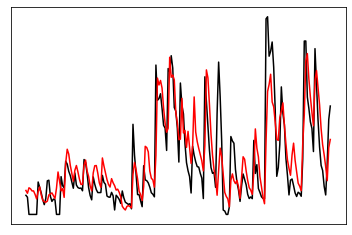

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4382.840323114836
            Iterations: 22
            Function evaluations: 59
            Gradient evaluations: 18
Target radar:  BE/ZAV
Coefficients: 
 [('DE/ESS', 0.04955143902422929), ('DE/NHB', 1.6422987771429057e-09), ('BE/WID', 1.5238511864234472e-09), ('BE/JAB', 0.028068781562794885), ('NL/DBL', 0.17070872114164698), ('BE/ZAV', 0.6294846164298916)]
Mean squared error: 721.06


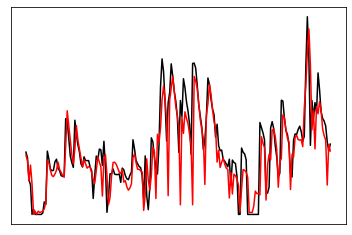

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 24656.677598942446
            Iterations: 17
            Function evaluations: 43
            Gradient evaluations: 13
Target radar:  DE/EIS
Coefficients: 
 [('DE/ISN', 0.0003038970922035963), ('DE/TUR', 8.19330076642969e-05), ('DE/NEU', 0.1528170453212112), ('DE/DRS', 0.0666926407507615), ('DE/EIS', 0.765425477809922)]
Mean squared error: 2086.30


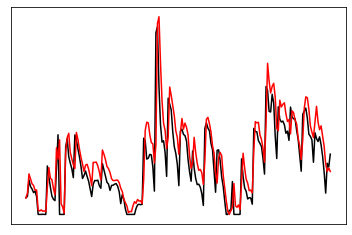

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 19078.49217330572
            Iterations: 24
            Function evaluations: 75
            Gradient evaluations: 20
Target radar:  DE/FBG
Coefficients: 
 [('DE/MEM', 0.13832098521999384), ('DE/OFT', 0.07255457858987141), ('DE/TUR', 0.06923297830592559), ('DE/NHB', 9.488746161359862e-10), ('BE/WID', 4.896159022566966e-05), ('DE/FBG', 0.6601711567798504)]
Mean squared error: 3787.98


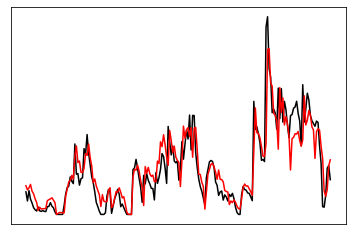

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 17579.609376493518
            Iterations: 19
            Function evaluations: 41
            Gradient evaluations: 15
Target radar:  DE/NEU
Coefficients: 
 [('DE/OFT', 0.0), ('DE/TUR', 0.0), ('DE/UMD', 0.05074202616429218), ('DE/EIS', 0.0), ('DE/FLD', 0.0001728774472066014), ('DE/DRS', 0.1925402567900365), ('DE/NEU', 0.6646597359154601)]
Mean squared error: 3903.34


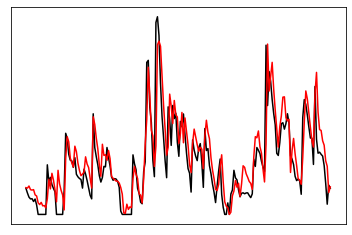

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 25880.297115428155
            Iterations: 28
            Function evaluations: 87
            Gradient evaluations: 24
Target radar:  DE/NHB
Coefficients: 
 [('DE/ESS', 0.23676072805583495), ('DE/OFT', 0.36006645563967743), ('BE/ZAV', 9.400438251440863e-06), ('DE/FBG', 0.0011950785686906593), ('BE/WID', 0.022484475197823636), ('DE/NHB', 0.4731469464149877)]
Mean squared error: 4583.58


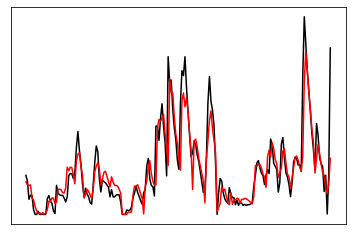

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 113746.76383018144
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Target radar:  DE/HNR
Coefficients: 
 [('DE/ESS', 0.21213736072433031), ('DE/UMD', 0.1755265614358037), ('DE/FLD', 0.22586767934541), ('DE/BOO', 0.06510519933125115), ('DE/EMD', 0.18742232915413534), ('DE/HNR', 0.39436791432362517)]
Mean squared error: 10409.19


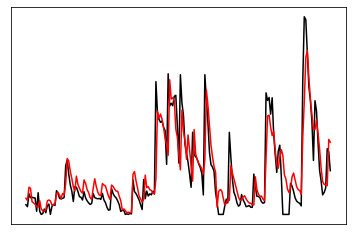

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6327.100059182183
            Iterations: 13
            Function evaluations: 32
            Gradient evaluations: 13
Target radar:  DE/ROS
Coefficients: 
 [('DE/PRO', 0.018569557861853964), ('DE/UMD', 0.020856911263769748), ('DE/BOO', 0.006400977756790165), ('DE/ROS', 0.8191267520117794)]
Mean squared error: 1991.58


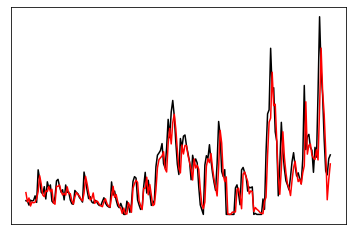

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 69123.31549828638
            Iterations: 18
            Function evaluations: 59
            Gradient evaluations: 14
Target radar:  BE/WID
Coefficients: 
 [('BE/ZAV', 0.1259347298814989), ('DE/FBG', 0.001052385196959213), ('DE/NHB', 0.06095496777099341), ('BE/WID', 0.9149282692768496)]
Mean squared error: 9938.37


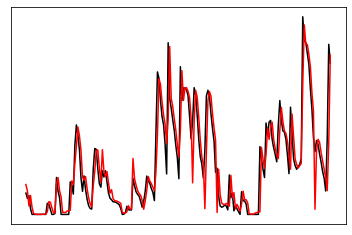

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 18712.106613063086
            Iterations: 18
            Function evaluations: 44
            Gradient evaluations: 14
Target radar:  BE/JAB
Coefficients: 
 [('BE/ZAV', 0.44081293535882426), ('NL/DBL', 0.0), ('NL/DHL', 0.0), ('BE/JAB', 0.6300688282406735)]
Mean squared error: 1105.56


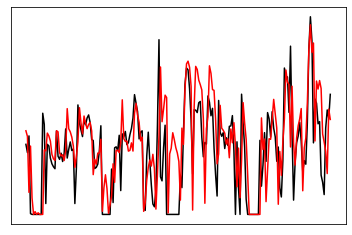

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 94832.19667415132
            Iterations: 18
            Function evaluations: 34
            Gradient evaluations: 14
Target radar:  DE/FLD
Coefficients: 
 [('DE/ESS', 0.0009332472940286065), ('DE/OFT', 0.0026095953191999917), ('DE/UMD', 0.21265281450509066), ('DE/NEU', 0.23091303714879488), ('DE/HNR', 0.08304754036189349), ('DE/FLD', 0.6641398444971015)]
Mean squared error: 11281.50


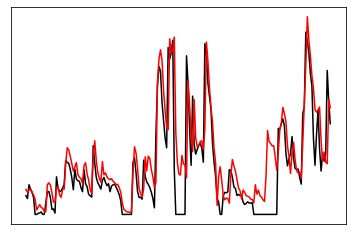

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12677.358495957333
            Iterations: 21
            Function evaluations: 52
            Gradient evaluations: 17
Target radar:  DE/BOO
Coefficients: 
 [('DE/UMD', 0.009851533004123593), ('DE/HNR', 0.04305757846836461), ('DE/ROS', 9.490299066616069e-11), ('DE/EMD', 9.47217075545035e-10), ('DE/BOO', 0.8133082264732526)]
Mean squared error: 1273.63


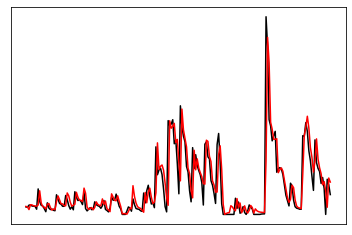

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 18612.163770526262
            Iterations: 19
            Function evaluations: 45
            Gradient evaluations: 15
Target radar:  DE/EMD
Coefficients: 
 [('DE/ESS', 7.547147758435408e-06), ('DE/HNR', 3.092672774581881e-08), ('DE/BOO', 0.8229211636820929), ('NL/DBL', 7.543616111177155e-10), ('NL/DHL', 5.172424769350409e-10), ('DE/EMD', 0.5804798866999602)]
Mean squared error: 3691.95


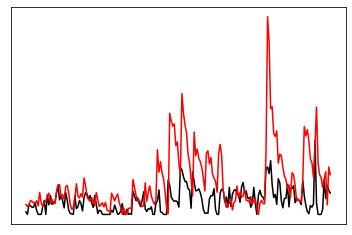

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 27119.26795404261
            Iterations: 16
            Function evaluations: 41
            Gradient evaluations: 12
Target radar:  DE/DRS
Coefficients: 
 [('DE/PRO', 0.17151314538185544), ('DE/UMD', 2.906400159103103e-06), ('DE/EIS', 3.9493705809505736e-07), ('DE/NEU', 0.019219861819833397), ('DE/DRS', 0.7983197032873038)]
Mean squared error: 12786.20


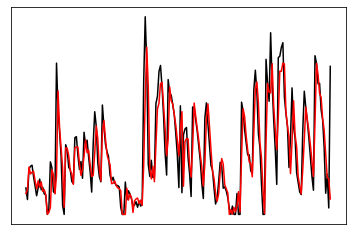

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7790.272186000111
            Iterations: 26
            Function evaluations: 76
            Gradient evaluations: 22
Target radar:  NL/DBL
Coefficients: 
 [('DE/ESS', 0.009413902969787809), ('BE/ZAV', 1.74845205595974e-09), ('BE/JAB', 2.332601206467495e-09), ('DE/EMD', 0.07760281896640608), ('NL/DHL', 0.32270310188825335), ('NL/DBL', 0.4997879603499769)]
Mean squared error: 1034.98


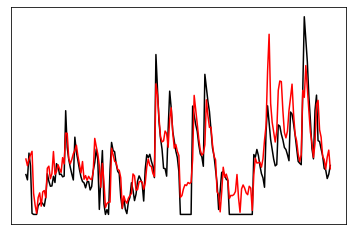

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 18200.405958569754
            Iterations: 13
            Function evaluations: 31
            Gradient evaluations: 13
Target radar:  NL/DHL
Coefficients: 
 [('BE/JAB', 0.1001546602188072), ('DE/EMD', 0.10492691180351696), ('NL/DBL', 0.0207641326797299), ('NL/DHL', 0.6814614847275124)]
Mean squared error: 3892.10


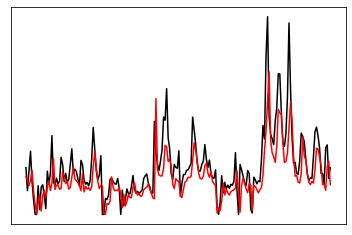

In [157]:
for idx in range(N):

    neighbours = np.concatenate((np.where(adj[idx]>0)[0], [idx]))
    X_train, y_train, X_test, y_test = train_test_split(X, Y, idx, neighbours)
    
    
    x0 = np.zeros(X_train.shape[1])
    bounds = Bounds(0, np.inf)
    res = minimize(loss, x0, args=(X_train, y_train), bounds=bounds,
                   method='SLSQP', jac=loss_der,  options={'ftol': 1e-9, 'disp': True})
    
    y_pred = res.x.T.dot(X_test.T)

    print('Target radar: ', names[reverse_map[idx]])
    print('Coefficients: \n', [(names[reverse_map[j]], res.x[i]) for i, j in enumerate(neighbours)])
    print('Mean squared error: %.2f'
          % loss(res.x, X_test, y_test))

    # Plot outputs
    plt.plot(y_test, color='black')
    plt.plot(y_pred, color='red')

    plt.xticks(())
    plt.yticks(())

    plt.show()

### Train on longer sequences

In [ ]:
edges = (adj > 0) # + np.eye(N, dtype=int)

boundary = ['DE/ROS', 'DE/PRO', 'DE/DRS', 'DE/EIS', 'DE/ISN', 'DE/MEM', 'DE/FBG', 
            'BE/WID', 'BE/ZAV', 'BE/JAB', 'NL/DHL']
targets = [i for i in range(N) if names[reverse_map[i]] not in boundary]

sources = np.concatenate([np.where(edges[idx])[0] for idx in targets])
x0 = np.concatenate([np.where(edges[idx])[0] == idx for idx in targets])
#x0 = np.random.rand(sources.size)
#x0 = np.zeros(sources.size)

eq_cons = {'type': 'ineq',
             'fun' : lambda x: np.array([1-x[np.where(sources==i)].sum() for i in targets])}#,
             #'jac' : lambda x: np.array([[source==i for source in sources] for i in range(N)])}

check = np.isfinite(d).all(axis=0)
X = np.zeros((N, 1))
Y = np.zeros((N, 1, 4))
for t in range(T-1)[::4]:
    if np.all(check[t:t+4]:
        X = np.concatenate((X, d[:, t][..., np.newaxis]), axis=1)
        Y = np.concatenate((Y, d[:, t+1:t+4][..., np.newaxis]), axis=1)
X = X[:,1:]
Y = Y[:,1:]

#scale = X.max(axis=0)
#X /= scale * 0.3
#Y /= scale * 0.3

X_train = X[:, 200:].T
Y_train = Y[:, 200:]

X_test = X[:, :200].T
Y_test = Y[:, :200]

method = 'SLSQP'
bounds = Bounds(0, 1)

print(eq_cons['fun'](x0))

def callback(xk):
    print(eq_cons['fun'](xk))
#method = 'L-BFGS-B'
#method = 'TNC'
#method = 'trust-constr'
res = minimize(loss_all, x0, args=(X_train, Y_train, edges, targets, sources), bounds=bounds, method=method, 
               #constraints=eq_cons, 
               jac=loss_der_all,  options={'ftol': 0, 'disp': True}, callback = callback, tol=10)
